# Анализ лояльности пользователей Яндекс Афиши

- Автор: Шабанов Виктор
- Дата: 21.10.2025

## Введение

### Цели и задачи проекта

В целях лучшего понимания поведение пользователей необходимо провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. Это позволит:
- Быстро выявлять перспективных клиентов и предлагать им персонализированные условия.
- Точно настраивать рекламу на аудитории с высокой вероятностью возврата.
- Оптимизировать маркетинговые бюджеты.
- Повысить общий уровень удержания клиентов.

### Содержимое проекта

1. **[Загрузка данных](#zagr)**
2. **[Предобработка данных](#predv)**
3. **[Создание профиля пользователя](#uprofil)**
4. **[Исследовательский анализ данных](#analiz)**
- 4.1. **[Исследование признаков первого заказа и их связи с возвращением на платформу](#analiz1)**
- 4.2. **[Исследование поведения пользователей через показатели выручки и состава заказа](#analiz2)**
- 4.3. **[Исследование временных характеристик первого заказа и их влияния на повторные покупки](#analiz3)**
- 4.4. **[Корреляционный анализ количества покупок и признаков пользователя](#analiz4)**

5. **[Общий вывод и рекомендации](#conclusion)**
6. **[Финализация проекта и публикация в Git](#final)**

## Этапы выполнения проекта
<a id='zagr'></a>
### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


Для дальнейшей выгрузки данных, их анализа в виде датафреймов и визуализации данных загрузим необходимые библиотеки языка python:

In [1]:
# pandas для работы с датафреймами
import pandas as pd
# для создания соединения с удаленным сервером PostgeSQL
# и последующего SQL запроса для наполнения датафрейма данными
from sqlalchemy import create_engine

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
from phik import phik_matrix

# Для работы с конфиденциальными данными
from dotenv import load_dotenv
import os

Используя заданные выше параметры подлкючения к базе данных `data-analyst-afisha` и загруженную функцию `create_engine` из библиотеки `sqlalchemy`, создадим подключение к удаленному `PostgeSQL` серверу. После этого при помощи SQL запроса выгрузим в датафрейм данные, соответствующие приведенному выше описанию. 

In [2]:
# Загрузка файла с конфедециальными данными
load_dotenv()

# Словарь с параметрами подключения к удаленному серверу PostgeSQL
db_config = {'user': os.getenv('SQL_USER'), # имя пользователя
             'pwd': os.getenv('SQL_PWD'), # пароль
             'host': os.getenv('SQL_HOST'),
             'port': os.getenv('SQL_PORT'), # порт подключения
             'db': os.getenv('SQL_DB') # название базы данных
             }
# Строка подключения
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
# Подключение
engine = create_engine(connection_string)
# SQL запрос к удаленному серверу для получения данных
query = '''
SELECT 
  user_id,
  device_type_canonical,
  order_id,
  created_dt_msk AS order_dt,
  created_ts_msk AS order_ts,
  currency_code,
  revenue,
  tickets_count,
  created_dt_msk::date - LAG(created_dt_msk::date) OVER (PARTITION BY user_id ORDER BY created_dt_msk) AS days_since_prev,
  event_id,
  service_name,
  event_type_main,
  region_name,
  city_name
FROM afisha.purchases
LEFT JOIN afisha.events USING(event_id)
LEFT JOIN afisha.city USING(city_id)
LEFT JOIN afisha.regions USING(region_id)
WHERE device_type_canonical IN ('mobile', 'desktop')
  AND event_type_main <> 'фильм'
ORDER BY user_id
'''
# Заполнение датафрейма
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

Получим информацию по получившемуся датафрейму:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

Выведем несколько первых строк датафрейма:

In [4]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк


Датафрейм содержит 14 столбцов и 290611 строк с информацией о покупках пользователями билетов на разные мероприятия у различных билетных операторов по разным городам и регионам.

После первичного анализац данных можно сделать следующие выводы:

- Колонки названы адекватно и отражают смысл содежращейся в них информации.
- Пропусков в датафрейме нет, кроме столбца `days_since_prev`, в котором пропуски связаны с тем, что нет предыдущей покупки. Эти пропуски можно смело заменить нулевым значением, тем самым отображая, что предыдущей покупки просто не было.
- Для некоторых числовых колонок можно предположить изменение в определенных ограниченных пределах, поэтому для них можно провести работу по оптимизации с понижением размерности.
- Некоторые категориальные стобцы могут потребовать нормализации для избавления от неявных дубликатов.

---
<a id='predv'></a>
###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


Анализируя уникальные значения в колонке `currency_code` (валюта оплаты) получим:

In [5]:
df['currency_code'].unique()

array(['rub', 'kzt'], dtype=object)

Выручка поступает в рублях и казахстанских тенге. Для анализа нужно привести выручку к единой валюте - рублям. Для этого воспользуемся датасетом с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`.

In [6]:
kurs_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
kurs_df.info()
kurs_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


Для поиска курса сначала преобразуем колонку `data` в датафрейме курсов к типу `datetime`:

In [7]:
kurs_df['data'] = pd.to_datetime(kurs_df['data'])

Теперь создадим функцию для заполнения новой колонки `revenue_rub` выручки в рублях и затем заполним колонку:

In [8]:
def sum_in_rub(row):
    if row['currency_code'] == 'kzt':
        search_curses = kurs_df[kurs_df['data'] == row['order_dt']]
        if search_curses.shape[0] == 0:
            return pd.NA
        else:
            kurs = search_curses.iloc[0]['curs']
            return row['revenue'] / 100. * kurs
    return row['revenue']

df['revenue_rub'] = df.apply(sum_in_rub, axis=1)

Так как для некоторых дат курc мог и не найтись в датафрейме с курсами, то нужно проверить новую колонку на пропуски:

In [9]:
df['revenue_rub'].isna().sum()

np.int64(0)

Всё в порядке, вся выручка в казахстанских тенге переведена в рубли.  

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

На следующем шаге проверим весь датафрейм с данными на пропуски:

In [10]:
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
service_name                 0
event_type_main              0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

Пропуски, как и ожидалось есть только в колонке `days_since_prev`. Пропуски в этой колонке появились из-за того, что в запросе, по которому заполнялся датафрейм, пустые значения полявлялись в том случае, если пользователь сделал только один заказ и предыдущего заказа просто не было. Проверим это. Получим записи с пропусками из датафрейма, затем полученные записи сгруппируем по пользователям и получим уникальные значения количества заказов на каждого пользователя для записей с пропусками в колонке `days_since_prev`:

In [11]:
# Записи датафрейма с пропусками в колонке days_since_prev
isna_df = df[df['days_since_prev'].isna()]
# Уникальные значения количества заказов на каждого пользователя для датафрейма только с пропусками
isna_df.groupby('user_id')['user_id'].count().unique()

array([1])

Получается, как и было сделано в запросе, пропуски проставлялись заказам, которые не имели предыдущего заказа, т.е. когда пользователь сделал только один заказ. В принципе, вместо пропусков можно поставить нулевое значение. Однако могут быть ситуации, когда пользователь сделал несколько заказов в один день. Тогда эти две ситуации сольются. Поэтому, чтобы в дальнейшем иметь возможность изменить тип колонки `days_since_prev` на `int` с возможностью уменьшения размерности и разделить две описанные ситуации, вместо пропусков проставим `-1`.

In [12]:
df['days_since_prev'].fillna(-1,  inplace=True)
df['days_since_prev'].isna().sum()

C:\Users\victor8632\AppData\Local\Temp\ipykernel_13916\823335642.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['days_since_prev'].fillna(-1,  inplace=True)


np.int64(0)

Теперь пропусков в вышеназванной колонке нет. При работе с колонкой `days_since_prev` будем в дальнейшем учитывать, что пропуски заменены на `-1`.

Займемся преобразованием типов для числовых колонок. Колонку `days_since_prev` мы избавили от пропусков. В ней хранится количество дей после предыдущей покупки. Эти числовые значения должны быть целыми и небольшими поэтому преобразуем тип этой колонки к типу `int` с уменьшением разрядности:

In [13]:
df['days_since_prev'] = pd.to_numeric(df['days_since_prev'], downcast='integer')

Значения выручки за билеты в каждом заказе предположительно тоже должны быть небольшими, прэтому проведем для них преобразование типов с уменьшением размерности:

In [14]:
df['revenue'] = pd.to_numeric(df['revenue'], downcast='float')
df['revenue_rub'] = pd.to_numeric(df['revenue_rub'], downcast='float')

Остальные колонки целочисленного типа тоже не должны содержать значения огромной величины, поэтому и для них проведем преобразование типов с уменьшением размерности. Затем посмотрим, что получилось:

In [15]:
for col in ['order_id', 'tickets_count', 'event_id']:
    df[col] = pd.to_numeric(df[col], downcast='integer')
df.dtypes

user_id                          object
device_type_canonical            object
order_id                          int32
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                      int8
days_since_prev                   int16
event_id                          int32
service_name                     object
event_type_main                  object
region_name                      object
city_name                        object
revenue_rub                     float64
dtype: object

Удалось уменьшить размерность числовых данных по сравнению с загруженными данными.

Проверим датафрейм с данными на явные дубликаты:

In [16]:
df.duplicated().sum()

np.int64(0)

Явных дубликатов нет. Однако, стоит проверить ситуацию, когда значнеия повторяются во всех колонках, кроме номера заказа и времени заказа. Такие ситуации возможны при технических сбоях с оборудованием.

In [17]:
#Получим все колонки, кроме order_id и order_ts:
test_col = []
pass_col = ['order_id', 'order_ts']
for col in df.columns:
    if not col in pass_col:
        test_col.append(col)

print(f'Количество дубликатов: {df.duplicated(subset=test_col).sum()}')
print(f'Доля  дубликатов: {df.duplicated(subset=test_col).mean():.2%}')
        
#df[test_col].nunique()        
df[df.duplicated(subset=test_col, keep=False)].sort_values(test_col).head(10)

Количество дубликатов: 39242
Доля  дубликатов: 13.50%


,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,revenue_rub
10,000cf0659a9f40f,mobile,6818249,2024-06-20,2024-06-20 10:49:48,rub,710.95,2,0,516728,Лови билет!,концерты,Широковская область,Радужнополье,710.95
12,000cf0659a9f40f,mobile,6818104,2024-06-20,2024-06-20 12:46:11,rub,710.95,2,0,516728,Лови билет!,концерты,Широковская область,Радужнополье,710.95
13,000cf0659a9f40f,mobile,6818075,2024-06-20,2024-06-20 12:42:12,rub,1421.91,4,0,516728,Лови билет!,концерты,Широковская область,Радужнополье,1421.91
14,000cf0659a9f40f,mobile,6818046,2024-06-20,2024-06-20 12:40:27,rub,1421.91,4,0,516728,Лови билет!,концерты,Широковская область,Радужнополье,1421.91
15,000cf0659a9f40f,mobile,6818220,2024-06-20,2024-06-20 10:56:16,rub,1421.91,4,0,516728,Лови билет!,концерты,Широковская область,Радужнополье,1421.91
16,000cf0659a9f40f,mobile,6818017,2024-06-20,2024-06-20 10:35:26,rub,1421.91,4,0,516728,Лови билет!,концерты,Широковская область,Радужнополье,1421.91
18,000cf0659a9f40f,mobile,6818162,2024-06-21,2024-06-21 04:18:44,rub,1066.43,3,0,516728,Лови билет!,концерты,Широковская область,Радужнополье,1066.43
19,000cf0659a9f40f,mobile,6817988,2024-06-21,2024-06-21 04:34:58,rub,1066.43,3,0,516728,Лови билет!,концерты,Широковская область,Радужнополье,1066.43
20,000cf0659a9f40f,mobile,6817959,2024-06-21,2024-06-21 04:33:56,rub,1066.43,3,0,516728,Лови билет!,концерты,Широковская область,Радужнополье,1066.43
21,000cf0659a9f40f,mobile,6759611,2024-06-21,2024-06-21 04:35:38,rub,1066.43,3,0,516728,Лови билет!,концерты,Широковская область,Радужнополье,1066.43


Из приведенной выше таблицы с примерами дубликатов видно, что дубликаты отличаются лишь временем записи, причем иногда разница сосставляет считанные минуты. Это явно ошибочные данные, которые могут существенно исказить дальнейший анализ. И хотя доля их достаточно велика 13.47% (что больше 5%), их придется удалить:

In [18]:
# Количество строк датафрейма ДО удаления
beg_count = df.shape[0]
df.drop_duplicates(subset=test_col, keep='first', inplace=True)

Теперь займемся неявными дубликатами в столбцах с категориальными значениями. Сначала посмотрим количество уникальных значений в каждой колонке, сделав сортировку по убыванию количества уникальных значений:

In [19]:
df.nunique().sort_values()

device_type_canonical         2
currency_code                 2
event_type_main               7
tickets_count                22
service_name                 36
region_name                  81
days_since_prev             150
order_dt                    153
city_name                   352
user_id                   21933
event_id                  22427
revenue                   42522
revenue_rub               43691
order_ts                 246701
order_id                 251369
dtype: int64

Первые две колонки `device_type_canonical` и `currency_code` не нуждаются в проверке потому что в них повторяются всего по два уникальных значения. Это неудивительно. Ведь смысл первой колонки - "тип устройства", а по условию мы при помощи SQL запроса выгружали данные только для двух типов устройств `mobile` и `desktop`. Так что все правильно. Смысл второй колонки - "валюта оплаты". Про нее мы ранее выяснили, что оплата поступала только в двух валютах: российских рублях (`rub`) и казахстанских тенге (`kzt`). Тоже все логично.

Следующую колонку `event_type_main` (основной тип мероприятия) проверим вручную, так как в ней уникальных вариантов немгого, всего 7 штук:

In [20]:
df['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

Несколько настораживает тип мероприятия `другое`. Это какой-то неопределенный тип, возможно, скрывающий пропуски. Посмотрим, сколько строк с такими значениями:

In [21]:
print('Cтроки с типом мероприятия "другое":\nАбсолютное количество: {}'.format((df['event_type_main'] == 'другое').sum()))
print('Доля от общего количества: {:.2%}'.format((df['event_type_main'] == 'другое').mean()))

Cтроки с типом мероприятия "другое":
Абсолютное количество: 58152
Доля от общего количества: 23.13%


Доля таких строк от общего количества достаточно велика 23.13%, поэтому исключать их нельзя. Но этот факт нужно учитывать при проведении исследовательского анализа данных.

Далее в топе по количеству уникальных значений идет числовая некатегориальная колонка `tickets_count`. Пропускаем. В следующей колонке `service_name`. Вручную неявные дубли уже не отследишь. Поэтому переведем названия билетных операторов в нижний регистр и проверим, изменится ли количество уникальных значений после этого: 

In [22]:
print('Количество уникальных значений в колонке "service_name":\nДО изменений: {}'.format(df['service_name'].nunique()))
print('ПОСЛЕ изменений: {}'.format(df['service_name'].str.lower().nunique()))

Количество уникальных значений в колонке "service_name":
ДО изменений: 36
ПОСЛЕ изменений: 36


Количество уникальных значений не изменилось. Значит неявных дублей, связанных с ошибочным вводом больших и маленьких букв нет. Оставляем колонку без изменения.

Проведем такие же манипуляции с двумя оставшимися категориальными колонками `region_name` (регион) и `city_name` (город):

In [23]:
for nm in ['region_name', 'city_name']:
    print('Количество уникальных значений в колонке "{}":\nДО изменений: {}'.format(nm, df[nm].nunique()))
    print('ПОСЛЕ изменений: {}'.format(df[nm].str.lower().nunique()))    

Количество уникальных значений в колонке "region_name":
ДО изменений: 81
ПОСЛЕ изменений: 81
Количество уникальных значений в колонке "city_name":
ДО изменений: 352
ПОСЛЕ изменений: 352


Здесь результат такой же, как и для колонки `service_name`. Поэтому преобразований для этих столбцов проводить не будем.

Для их анализа выделим численные данные:

In [24]:
df.select_dtypes(include='number').columns

Index(['order_id', 'revenue', 'tickets_count', 'days_since_prev', 'event_id',
       'revenue_rub'],
      dtype='object')

Из анализа исключим столбцы `order_id` (уникальный идентификатор заказа) и `event_id` (уникальный идентификатор мероприятия), так как, исходя из их смыслового содержания числовой анализ будет просто бессымсленным. 

Также исключим колонку `revenue`, которая содержит выручку в разных валютах и априори будет содержать несравнимые данные из-за разного числового масштаба валют. Вместо нее будем анализировать данные в столбце `revenue_rub`, где суммы приведены к одной валюте - российским рублям. Статистические показатели по этой колонке будут следующими:

In [25]:
df['revenue_rub'].describe()

count    251369.000000
mean        567.683054
std         901.130179
min         -90.760000
25%         123.840000
50%         370.750000
75%         817.530000
max       81174.540000
Name: revenue_rub, dtype: float64

Из полученных статистических показателей следует, что есть выручка с отрицательными значениями. Видимо, были каки-то возвраты. Отрицательные значения в выручке для последующей работы нам не нужны, поэтому нужно оценить количество записей с ними и по возможности удалить.

In [26]:
print('Cтроки с отрицательной выручкой:\nАбсолютное количество: {}'.format((df['revenue_rub'] < 0).sum()))
print('Доля от общего количества: {:.3%}'.format((df['revenue_rub'] < 0).mean()))

Cтроки с отрицательной выручкой:
Абсолютное количество: 342
Доля от общего количества: 0.136%


Доля записей с отрицательной выручкой составляет всего чуть больше десятой процента (0.136%), поэтому их можно удалить без всяковго ущерба для далнейшей работы. После удаления посмотрим новый вариант статистических показателей для колонки `revenue_rub`:

In [27]:
# Удаление записей с отрицательной выручкой
df = df[df['revenue_rub'] >= 0]
# Статистические показатели
df['revenue_rub'].describe()

count    251027.00000
mean        568.45990
std         901.49782
min           0.00000
25%         124.70000
50%         371.77000
75%         818.28000
max       81174.54000
Name: revenue_rub, dtype: float64

Можно предположить, что распределение рублевой выручки является ассиметричным, скошенным вправо, так как среднее значение превышает медианное больше чем в полтора раза. Минимальное значение равно нулю, что говорит о том, что некоторые билеты раздавались без выручки, т.е. даром. Максимальное значение на несколько порядков превышает как среднее, так и медианное, что говорит о наличии выбросов, требующих дальнейшего анализа.

Сначала построим диаграмму распределения:

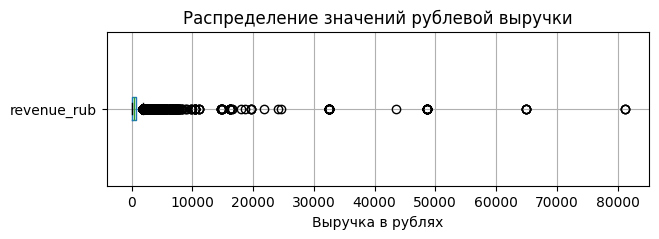

In [28]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 2))

# Строим диаграмму размаха значений в столбце выручки
df.boxplot(column='revenue_rub', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение значений рублевой выручки')
plt.xlabel('Выручка в рублях')

# Выводим график
plt.show()

Диаграмма распределения показывает очень много выбросов. Причем выбросов со значениями, близкими к максимальным не очень много. Мы безболезенно можем расстаться с примерно с 1% данных. Поэтому отфильтруем значения по 99 перцентилю: 

In [29]:
rev99 = df['revenue_rub'].quantile(0.99)
print(f'Выручка, соответствующая 99 перцентилю: {rev99:.2f}')
print('Cтроки с выручкой больше 99 перцентиля:\nАбсолютное количество: {}'.format((df['revenue_rub'] > rev99).sum()))
print('Доля от общего количества: {:.3%}'.format((df['revenue_rub'] > rev99).mean()))

Выручка, соответствующая 99 перцентилю: 2609.81
Cтроки с выручкой больше 99 перцентиля:
Абсолютное количество: 2511
Доля от общего количества: 1.000%


Удалим процент данных с максимальными значениями выручки и посмотрим, сколько всего удалено строк по сравнению с первоначальным состоянием датафрейма:

In [30]:
# Удаление записей с отрицательной выручкой
df = df[df['revenue_rub'] <= rev99]
print(f'Первоначальное количество строк: {beg_count}')
print('Удалено строк: {}'.format(beg_count - df.shape[0]))
print('Текущее количество строк: {}'.format(df.shape[0]))
print('Доля удадаленных строк от первоначального количества: {:.2%}'.format((beg_count - df.shape[0])/beg_count))

Первоначальное количество строк: 290611
Удалено строк: 42095
Текущее количество строк: 248516
Доля удадаленных строк от первоначального количества: 14.48%


Теперь заново получим статистические показатели:

In [31]:
# Статистические показатели
df['revenue_rub'].describe()

count    248516.000000
mean        529.577032
std         509.227435
min           0.000000
25%         122.510000
50%         364.860000
75%         802.050000
max        2609.370000
Name: revenue_rub, dtype: float64

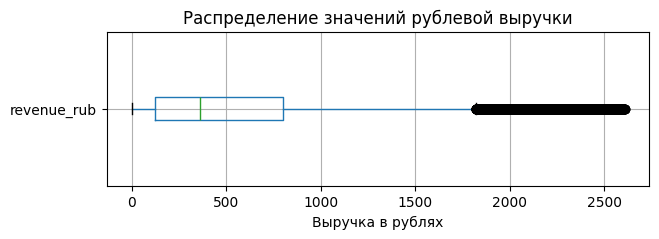

In [32]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 2))

# Строим диаграмму размаха значений в столбце выручки
df.boxplot(column='revenue_rub', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение значений рублевой выручки')
plt.xlabel('Выручка в рублях')

# Выводим график
plt.show()

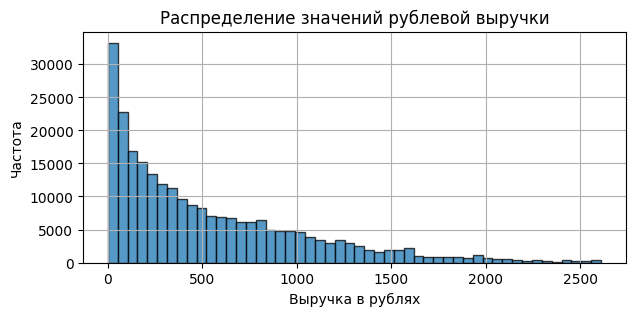

In [33]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим гистограмму с помощью pandas через plot(kind='hist')
df['revenue_rub'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=50, # Устанавливаем количество корзин
                alpha=0.75,
                edgecolor='black',
                rot=0, # Градус вращения подписи по оси Х
)

# Настраиваем оформление графика
plt.title('Распределение значений рублевой выручки')
plt.xlabel('Выручка в рублях')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Судя по окнчательным статистическим параметрам мы действительно имеем асимметричное распределение, скошенное вправо, с длинным хвостом, причем выбросы являются равномерным продолжением основной части. В этом распределении множество нулевых значений: 

In [34]:
df['revenue_rub'].value_counts().head()

revenue_rub
0.00       4346
1183.35     674
788.90      613
1577.80     457
613.17      394
Name: count, dtype: int64

Их число (4346) значительно превышает количество других значений выручки.

Теперь рассмотрим распределение значений в другом важном столбце `tickets_count` (количество купленных билетов). Статистические параметры для этого столбца будут следующими:

In [35]:
df['tickets_count'].describe()

count    248516.000000
mean          2.738918
std           1.163456
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

В данном случае мы имеем дело с распределением, близким к нормальному (среднее значение практически совпадает с медианным). Из параметров следует, что покупают обычно три билета. Это подтверждатеся топом заказов с различным значеним купленных билетов:

In [36]:
df['tickets_count'].value_counts().head(10)

tickets_count
3     78842
2     72251
4     46592
1     36278
5     11035
6      3354
7        52
9        34
10       18
8        18
Name: count, dtype: int64

Количество покупок трех билетов составляет 78842. Примерно столько же покупок двух билетов - 72251. После шести билетов количество случаев покуок резко падает и переходит в разряд откровенных выбросов. Выбросы связаны, видимо, с групповыми походами на культурные мероприятия, которых, конечно, значительно меньше, чем индивидуальных.

Построим гистограмму распределения для случаев покупки 6 билетов и меньше:

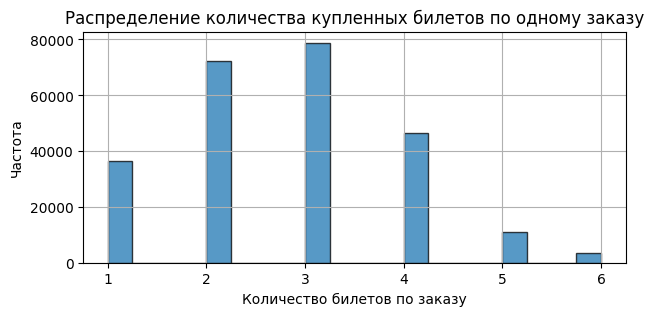

In [37]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим гистограмму с помощью pandas через plot(kind='hist')
df[df['tickets_count'] <= 6]['tickets_count'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=20, # Устанавливаем количество корзин
                alpha=0.75,
                edgecolor='black',
                rot=0, # Градус вращения подписи по оси Х
)

# Настраиваем оформление графика
plt.title('Распределение количества купленных билетов по одному заказу')
plt.xlabel('Количество билетов по заказу')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Гистограмма подтверждает гипотезу о распределении, близкому к нормальному.

Осталось проанализировать числовую колонку `days_since_prev` (количество дней от предыдущей покупки пользователя). Посмотрим число повторов значений в этой колонке:

In [38]:
print(f'Всего строк в датафрейме: {df.shape[0]}')
dfp = df[df['days_since_prev']>=0]
print('\nТоп количества повторов значений количества дней от предыдущей покупки пользователя:')
print(dfp['days_since_prev'].value_counts().head())
print('Доля заказов с лишь одной покупкой: {:.2%}'.format(dfp['days_since_prev'].value_counts().head(1)[0]/dfp.shape[0]))

Всего строк в датафрейме: 248516

Топ количества повторов значений количества дней от предыдущей покупки пользователя:
days_since_prev
0    143126
1     30161
2      9839
3      6118
4      4352
Name: count, dtype: int64
Доля заказов с лишь одной покупкой: 63.09%


В подавляющем большинстве случаев повторных покупок просто нет (63.09%). Эти покупки лучше выделить в отдельную категорию. Теперь, если рассматривать ненулевые значения дней между покупками получим следующие статистические параметры: 

In [39]:
dfp[dfp['days_since_prev'] > 0]['days_since_prev'].describe()

count    83719.000000
mean        10.232146
std         18.373301
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max        148.000000
Name: days_since_prev, dtype: float64

C:\Users\victor8632\AppData\Local\Temp\ipykernel_13916\2884390375.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfp[df['days_since_prev'] > 0].boxplot(column='days_since_prev', vert=False)


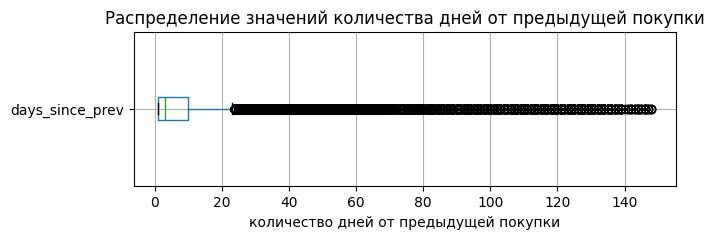

In [40]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 2))

# Строим диаграмму размаха значений в столбце выручки
dfp[df['days_since_prev'] > 0].boxplot(column='days_since_prev', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение значений количества дней от предыдущей покупки')
plt.xlabel('количество дней от предыдущей покупки')

# Выводим график
plt.show()

Исходя из полученных статистических данных можно сделать однозначный вывод, что распределение значений в колонке `days_since_prev` ассиметричное, скошенное вправо. Медианный период между текущей и предыдущей покупкой составляет три дня. Количество случаев увеличения периода резко падает и далее постепенно уменьшается.

Во время предварительной обработки данных была проведена следующая работа:
- Так как в загруженном датафрейме в колонке `revenue` содежрались значения выручки в двух валютах - российских рублях и казахстанских тенге - в зависимости от значения в столбце `currency_code`, то пришлось добавить колонку `revenue_rub`, куда была помещена пересчитанная выручка в российских рублях. При пересчете выручка в российских рублях переносилась в новый столбец без изменения, а в казастанских тенге выручка пересчитывалась с использованием загруженного файла курса валют казахстанского тенге в российских рублях за 2024 год.
- При проверке колонок на пропуски оные были обнаружены только в колонке `days_since_prev` (количество дней от предыдущей покупки пользователя). Эти пропуски вполне объяснимы и связаны с тем, что покупка была единичной и предыдущей покупки просто не было. Поэтому эти пропуски были заменены нулевыми значениями.
- Для числовых колонк были произведены преобразования типов. Числовые колонки по возможности были преобразованы к соответствующим типам с уменьшением размерности.
- В датафрейме не было обнаружено явных дубликатов. В строковых столбцах не было обнаружено неявных дубликатов, даже после попытки нормализации данных. В колонке `event_type_main` (основной тип мероприятия) среди уникальных значений было обнаружено неоднозначное значение `другое`, которое говорит о неопределенном типе мероприятия, возможно, пропуске. Это надо учитывать при последующем анализе.
- При анализе колонки `revenue_rub` (рублевая выручка) были обнаружены отрицательные значения, возможно, возвараты. Доля количества строк с отрицательными значениями рублевой выручки от общего количества строк составила 0.131%. Поэтому было решено удалить их из датафрейма.
- При статистическом анализе колонки `revenue_rub` было выявлено, что максимальное значение выручки на несколько порядков превосходит как медианное, так и среднее значение. Выручка, соответствующая 99 перценталю также оказалась примерно в 40 раз меньше максимального значения. Поэтому было решено удалить из датафрейма строки с выручкой, превышающей её значение для 99 перценталя. Всего с учетом удаления дублей записей с одинаковыми значениями во всех колонках, кроме номера заказа и времени, а также отрицательных значений выручки было удалено 42095 строк, что составило 14.48% от общего количества строк.
- При проведении статистического анализа количества купленных билетов в одном заказе было обнаружено, что распределение в этой колонки является близким к нормальному. Среднее количество билетов на один заказ равно трем. Максимальное значени составляет 57 и такие выбросы связаны, видимо с групповыми посещениями мероприятий.
- Анализ количества дней, прошедших с предыдущей покупки показал, что наибольшее количество покупок совершалось лишь единожды (70.86% от всех покупок). Если исключить эти покупки, остальные случи имеют ассиметричное распределение, скошенное вправо с медианным значением в три дня и стандартным отклонением в 18 дней.

---
<a id='uprofil'></a>
### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь больше двух заказов;
- `is_five` — совершил ли пользователь больше пяти заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


Так как датафрейм профиля пользователя будет содержать строковые колонки, относящиеся к первому сделанному заказу тем или иным пользователем, то сначала отсортируем текущий датафрейм о времени совершения заказа:

In [41]:
df = df.sort_values('order_ts')

Теперь создадим первоначальный профиль пользователя с колонками, которые можно получить группировкой:

In [42]:
# Функция определения среднего времени между заказами
def get_days_since_prev_mean(row):
    # если заказ один, то время между заказми нельзя определить - возвращаем 0
    if row['orders_count'] <= 1:
        return 0
    # если заказов больше одного, то суммарное время делим на количество заказов минус 1
    # первый заказ при учете среднего не учитываем, так как для него нет предыдущего заказа.
    return row['days_since_prev_sum'] / (row['orders_count'] - 1)

# Колонки профиля, которые можно получить группировкой 
df['days_since_prev_for_sum'] = df['days_since_prev'].where(df['days_since_prev']!=-1,0)
uprofil0_df = df.groupby('user_id', as_index=False).agg(
    {'order_ts':['min', 'max'], 
     'order_id':'count', 
     'revenue_rub':'mean',
     'tickets_count':'mean',
     'days_since_prev_for_sum':'sum'
    })

# По-своему называем колонки и заодно избавляемся от группировки колонок 
uprofil0_df.columns = ['user_id',
                      'order_ts_first',
                      'order_ts_last',
                      'orders_count', 
                      'revenue_rub_mean', 
                      'tickets_mean',
                      'days_since_prev_sum'
                     ]

# Заполняем колонку среднего времени между заказами
uprofil0_df['days_since_prev_mean'] = uprofil0_df.apply(get_days_since_prev_mean, axis=1)
# Удаляем колонку с суммарным временем между заказами
del uprofil0_df['days_since_prev_sum']
print(f'Количество строк: {uprofil0_df.shape[0]}')
uprofil0_df.head()

Количество строк: 21824


,user_id,order_ts_first,order_ts_last,orders_count,revenue_rub_mean,tickets_mean,days_since_prev_mean
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,1,1521.940000,4.000000,0.0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,2,774.010000,3.000000,75.0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,3,767.213333,2.666667,51.0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,1,917.830000,4.000000,0.0
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,2,61.310000,1.500000,16.0


Добавляем колонки, связанные с первым заказом:

In [43]:
# Из исходного датафрейма возьмем только те колонки, которые нужны в профиле пользователя
dfc = df[['user_id','order_ts','device_type_canonical','region_name','service_name','event_type_main']].copy()
# Присоединим эти колонки к уже имеющемуся первоначальному профилю пользователя
uprofil_df = uprofil0_df.merge(dfc, left_on=['user_id', 'order_ts_first'], right_on=['user_id', 'order_ts'], how='inner')
# Удалим ненужное
del uprofil_df['order_ts']
# Переименуем присоединенное
uprofil_df.rename(columns={'device_type_canonical': 'device_type_first', 
                           'region_name': 'region_name_first',
                           'service_name': 'service_name_first',
                           'event_type_main': 'event_type_first'
                          }, inplace=True)
print(f'Количество строк после добавления колонок: {uprofil_df.shape[0]}')
uprofil_df.head()

Количество строк после добавления колонок: 21825


,user_id,order_ts_first,order_ts_last,orders_count,revenue_rub_mean,tickets_mean,days_since_prev_mean,device_type_first,region_name_first,service_name_first,event_type_first
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,1,1521.940000,4.000000,0.0,mobile,Каменевский регион,Край билетов,театр
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,2,774.010000,3.000000,75.0,mobile,Каменевский регион,Мой билет,выставки
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,3,767.213333,2.666667,51.0,mobile,Североярская область,Лови билет!,другое
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,1,917.830000,4.000000,0.0,desktop,Каменевский регион,Край билетов,театр
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,2,61.310000,1.500000,16.0,mobile,Поленовский край,Лучшие билеты,театр


После добавления к перовначальному датафрейму пользователя колонок, связанных с первым заказом пользователя, количество строк датафрейма не изменилось. Значит, все прошло без искажений.

Теперь добавим два бинарных признака, небходимых для дальнейших исслеований и проверим получившийся результат:

In [44]:
# Функция для заполнения бинарных признаков
# lim_count_ord - предел минимального количества заказов (включительно)
def is_count_orders(row, lim_count_ord):
    if lim_count_ord == 2:
        return row['orders_count'] >= 2
    elif lim_count_ord == 5:
        return row['orders_count'] >= 5
    return False

# Заполнение бинарных признаков
uprofil_df['is_two'] = uprofil_df.apply(is_count_orders, axis=1, args=(2,))
uprofil_df['is_five'] = uprofil_df.apply(is_count_orders, axis=1, args=(5,))
uprofil_df.info()
uprofil_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21825 entries, 0 to 21824
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               21825 non-null  object        
 1   order_ts_first        21825 non-null  datetime64[ns]
 2   order_ts_last         21825 non-null  datetime64[ns]
 3   orders_count          21825 non-null  int64         
 4   revenue_rub_mean      21825 non-null  float64       
 5   tickets_mean          21825 non-null  float64       
 6   days_since_prev_mean  21825 non-null  float64       
 7   device_type_first     21825 non-null  object        
 8   region_name_first     21825 non-null  object        
 9   service_name_first    21825 non-null  object        
 10  event_type_first      21825 non-null  object        
 11  is_two                21825 non-null  bool          
 12  is_five               21825 non-null  bool          
dtypes: bool(2), date

,user_id,order_ts_first,order_ts_last,orders_count,revenue_rub_mean,tickets_mean,days_since_prev_mean,device_type_first,region_name_first,service_name_first,event_type_first,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,1,1521.940000,4.000000,0.0,mobile,Каменевский регион,Край билетов,театр,False,False
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,2,774.010000,3.000000,75.0,mobile,Каменевский регион,Мой билет,выставки,True,False
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,3,767.213333,2.666667,51.0,mobile,Североярская область,Лови билет!,другое,True,False
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,1,917.830000,4.000000,0.0,desktop,Каменевский регион,Край билетов,театр,False,False
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,2,61.310000,1.500000,16.0,mobile,Поленовский край,Лучшие билеты,театр,True,False


Таким образом, мы создали датафрейм с профилями пользователей, который содержит 13 колонок и 21825 строк. Датафрейм содержит следующие столбцы:

- `user_id` - уникальный идентификатор пользователя, совершившего заказ;
- `order_ts_first` - дата первого заказа;
- `order_ts_last` - дата последнего заказа;
- `orders_count` - общее количество заказов;
- `revenue_rub_mean` - средняя выручка с одного заказа в рублях;
- `tickets_mean` - среднее количество билетов в заказе;
- `days_since_prev_mean` - среднее время между заказами;
- `device_type_first` - устройство, с которого был сделан первый заказ;
- `region_name_first` - регион, в котором был сделан первый заказ;
- `service_name_first` - билетного партнёра, к которому обращались при первом заказе;
- `event_type_first` - жанр первого посещённого мероприятия;
- `is_two` - совершил ли пользователь 2 и более заказов;
- `is_five` - совершил ли пользователь 5 и более заказов.

---
<a id='task3_2'></a>
**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших более 2 и более 5 заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

Проведем проверку созданного датафрейма с профилями пользователей.

Сравним количество профилей пользователй в новом датафрейме с количеством пользователей в исходном датафрейме:

In [45]:
print('Количество пользователей в исходном датафрейме: {}'.format(df['user_id'].nunique()+1))
print('Количество профилей пользователей: {}'.format(uprofil_df.shape[0]))

Количество пользователей в исходном датафрейме: 21825
Количество профилей пользователей: 21825


Количество пользователей в исходном датафрейме и количество профилей пользователей в новом полученном датафрейме совпадают. Значит, в этом случае все правильно.

Сравним среднюю рублевую выручку с одного заказа в исходном датафрейме и в датафрейме с профилями пользователей:

In [46]:
print('Средняя выручка в исходном датафрейме: {:.2f}'.format(df['revenue_rub'].mean()))
print('Средняя выручка в датафрейме профилей пользователей: {:.2f}'.format(uprofil_df['revenue_rub_mean'].mean()))

Средняя выручка в исходном датафрейме: 529.58
Средняя выручка в датафрейме профилей пользователей: 543.13


В данном случае значения немного различаются, но это связано с тем, что в датафрейме профилей пользователей мы получаем среднее от среднего, поэтому эта небольшая разница является приемлемой.

Посмотрим долю пользователей, совершивших 2 и более и 5 и более заказов:

In [47]:
count_uprofil = uprofil_df.shape[0]
count_is_two = uprofil_df['is_two'].sum()
count_is_five = uprofil_df['is_five'].sum()
print('Пользователи, сделавшие:\n')
print(f'- 2 и более заказов: {count_is_two}, доля от общего количества: {count_is_two/count_uprofil:.2%}')
print(f'- 5 и более заказов: {count_is_five}, доля от общего количества: {count_is_five/count_uprofil:.2%}')

Пользователи, сделавшие:

- 2 и более заказов: 13467, доля от общего количества: 61.70%
- 5 и более заказов: 5894, доля от общего количества: 27.01%


Получается около 40% пользователей делают всего один заказ и обратно не возвращаются. Очень печальный факт.

Изучение остальных статистических показателей начнем с среднего числа билетов в заказе `tickets_mean`. Статистические параметры (включая 95 и 99 перцентили):

In [48]:
uprofil_df['tickets_mean'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

count    21825.000000
mean         2.742284
std          0.909521
min          1.000000
25%          2.000000
50%          2.750000
75%          3.041667
95%          4.000000
99%          5.000000
max         11.000000
Name: tickets_mean, dtype: float64

Максимальное значение количества билетов здесь вдвое превышает значение 99 перцентиля. Безусловно есть выбросы. Посмотрим распределение значений среднего количества билетов превышающих значение для 99 перцентиля:

In [49]:
uprofil_df[uprofil_df['tickets_mean'] > 5]['tickets_mean'].value_counts().head(10)

tickets_mean
6.000000     136
5.500000      18
5.333333       7
7.000000       4
5.666667       4
5.250000       2
10.000000      2
5.125000       1
9.000000       1
11.000000      1
Name: count, dtype: int64

Для вариантов болше 6 билетов количество профилей пользователей резко падает и общее число таких профилей составляет:

In [50]:
(uprofil_df['tickets_mean'] > 6).sum()

np.int64(12)

Таким количеством профилей ползователей можно пренебречь. Удалим из датафрейма с профилями пользователей. И после получим новый набор статистических параметров:

In [51]:
uprofil_df = uprofil_df[uprofil_df['tickets_mean'] <= 6]
uprofil_df['tickets_mean'].describe()

count    21813.000000
mean         2.739338
std          0.900330
min          1.000000
25%          2.000000
50%          2.750000
75%          3.033333
max          6.000000
Name: tickets_mean, dtype: float64

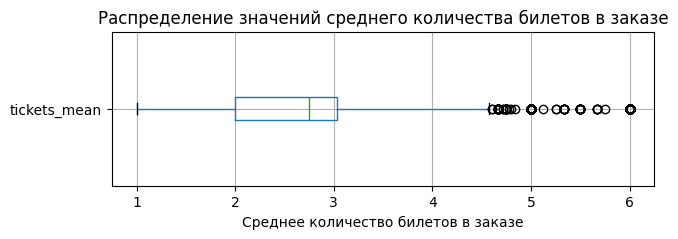

In [52]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 2))

# Строим диаграмму размаха значений в столбце выручки
uprofil_df.boxplot(column='tickets_mean', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение значений среднего количества билетов в заказе')
plt.xlabel('Среднее количество билетов в заказе')

# Выводим график
plt.show()

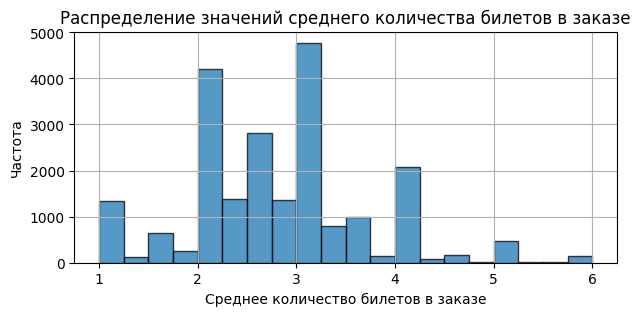

In [53]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим гистограмму с помощью pandas через plot(kind='hist')
uprofil_df['tickets_mean'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=20, # Устанавливаем количество корзин
                alpha=0.75,
                edgecolor='black',
                rot=0, # Градус вращения подписи по оси Х
)

# Настраиваем оформление графика
plt.title('Распределение значений среднего количества билетов в заказе')
plt.xlabel('Среднее количество билетов в заказе')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Распределение среднего количества билетов в одном заказе близко с нормальному. Медианное и среднее значение практически совпадают. выбросов немного и они примыкают к основному распределению.

Теперь перейдем к статистическим параметрам общего количества заказов каждого пользователя:

In [54]:
uprofil_df['orders_count'].describe()

count    21813.000000
mean        11.392060
std        102.400371
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       8700.000000
Name: orders_count, dtype: float64

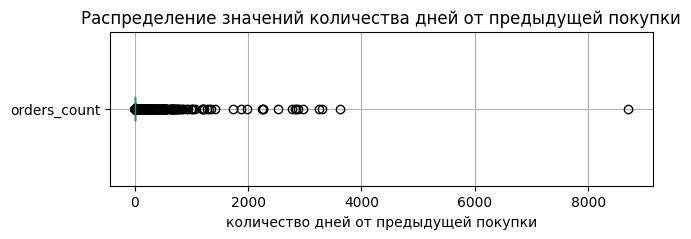

In [55]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 2))

# Строим диаграмму размаха значений в столбце выручки
uprofil_df.boxplot(column='orders_count', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение значений количества дней от предыдущей покупки')
plt.xlabel('количество дней от предыдущей покупки')

# Выводим график
plt.show()

В случае с общим количеством заказов пользователя распределение ассиметричное, скошенное вправо, так как среднее значение в несколько раз больше, чем медианное. Максимальное значение на несколько порядков превышает как медианное, так и среднее значение, что предполагает множество выбросов. Это подтверждает диаграмма размаха. Такое впечатление, что она состоит из одних выбросов. Посмотрим профили пользователя для максимального значения среднего количества заказов (это максимальный выброс): 

In [56]:
uprofil_df[uprofil_df['orders_count'] == 8700]

,user_id,order_ts_first,order_ts_last,orders_count,revenue_rub_mean,tickets_mean,days_since_prev_mean,device_type_first,region_name_first,service_name_first,event_type_first,is_two,is_five
980,0beb8fc0c0a9ce1,2024-06-01 00:18:28,2024-10-31 23:25:38,8700,512.375114,2.881264,0.017243,mobile,Североярская область,Билеты в руки,концерты,True,True


Только один пользователь сделал столько заказов. Средняя выручка и среднее количество билетов на один заказ у него близки к средним значениям. Можно предположить, что мы имеем дело с посредником, который переправляет заказы своих клиентов в Яндекс Афишу и потом перепродает им билеты с некоторой наценкой. Получается, что в данном случае выбросы убирать из датафрейма нельзя, чтобы не потерять профили клиентов со специфическим поведением.

Перейдем к изучению статистических показателей колонки `days_since_prev_mean` (среднее время между заказами). При получении подобных показателей для аналогичного столбца исходного датафрейма было выяснено, что подавляющем количестве строк колонка заполнена нулевыми значениями (заказ был всего один и предыдущего закзаза не было). Сделаем проверку нулевых значений в колонке `days_since_prev_mean`:

In [57]:
days_since_prev0 = (uprofil_df['days_since_prev_mean'] == 0).sum()
print('Профили с days_since_prev_mean = 0:')
print(f'Абсолюное значение: {days_since_prev0}')
print('Доля от общего количества профилей: {:.2%}'.format(days_since_prev0/uprofil_df.shape[0]))

Профили с days_since_prev_mean = 0:
Абсолюное значение: 11064
Доля от общего количества профилей: 50.72%


Доля профилей пользователей с нулевыми значениями среднего времени между заказами значительна, поэтому исключим строки с нулевыми значениями при получениями статистических показателей:

In [58]:
uprofil_df[uprofil_df['days_since_prev_mean']>0]['days_since_prev_mean'].describe()

count    10749.000000
mean        20.500529
std         23.272861
min          0.017243
25%          5.720000
50%         12.750000
75%         26.000000
max        148.000000
Name: days_since_prev_mean, dtype: float64

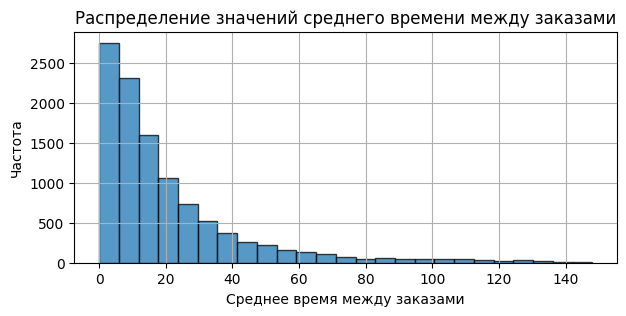

In [59]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим гистограмму с помощью pandas через plot(kind='hist')
uprofil_df[uprofil_df['days_since_prev_mean'] > 0]['days_since_prev_mean'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=25, # Устанавливаем количество корзин
                alpha=0.75,
                edgecolor='black',
                rot=0, # Градус вращения подписи по оси Х
)

# Настраиваем оформление графика
plt.title('Распределение значений среднего времени между заказами')
plt.xlabel('Среднее время между заказами')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Гистограмма показывает, что распределение значений среднего времени между заказами является асинхронным с сильным сдвигом вправо. Причем частота изменения значений плавно снижается. Это означает, что в большинстве случаев следующий заказ делается через небольшое время (медианное значение составляет 12 дней). Количество случаев, когда заказ делают через продолжительное время (например, через несколько месяцев) исчезающе мало.

---
<a id='analiz'></a>
### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.


<a id='analiz1'></a>
#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


Изучение распределения пользователей по признакам начнем с их группировки.

По типу первого посещенного мероприятия пользователи распределились следующим образом:

In [60]:
# Функция для формирования датафрейма для заданного параметра
def get_top_param(name_col, name_param, count_top=10):
    conts_df = uprofil_df[name_col].value_counts().head(count_top).to_frame().reset_index()
    conts_df.columns = [name_param,'Количество']
    conts_df['Доля'] = conts_df['Количество'] / uprofil_df.shape[0]
    return conts_df

# Для параметра 'Тип мероприятия'
conts_df = get_top_param('event_type_first', 'Тип мероприятия')
conts_df

,Тип мероприятия,Количество,Доля
0,концерты,9629,0.441434
1,другое,5455,0.250080
2,театр,4299,0.197084
3,стендап,1118,0.051254
4,спорт,801,0.036721
5,выставки,416,0.019071
6,ёлки,95,0.004355


В виде столбчатой диаграммы это будет выглядеть так:

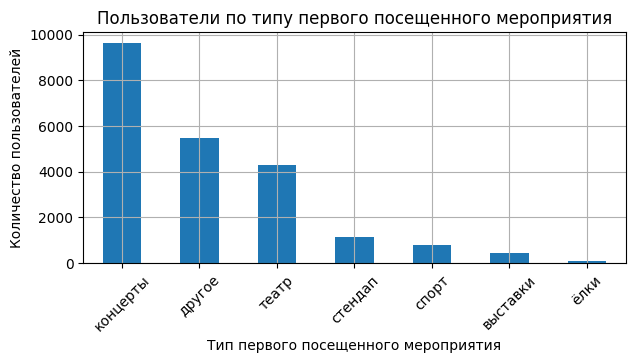

In [61]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
uprofil_df['event_type_first'].value_counts().plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=45, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Пользователи по типу первого посещенного мероприятия'
)

# Настраиваем оформление графика
plt.xlabel('Тип первого посещенного мероприятия')
plt.ylabel('Количество пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Долю каждого сегмента представим в виде круговой диаграммы:

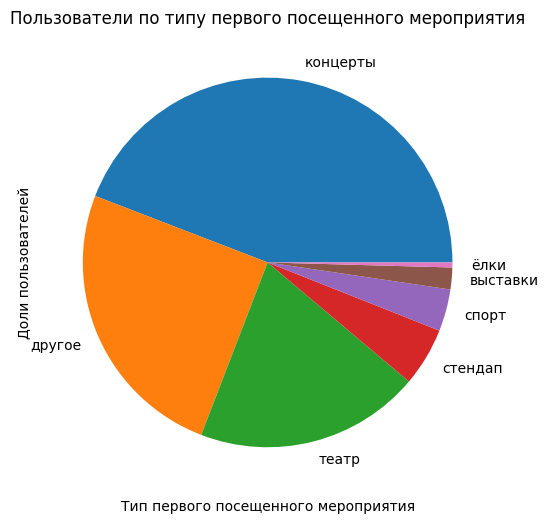

In [62]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 6))

# Строим круговую диаграмму с помощью pandas через plot(kind='pie')
uprofil_df['event_type_first'].value_counts().plot(
               kind='pie', # Тип графика — круговая диаграмма
               title=f'Пользователи по типу первого посещенного мероприятия'
)

# Настраиваем оформление графика
plt.xlabel('Тип первого посещенного мероприятия')
plt.ylabel('Доли пользователей')

# Выводим график
plt.show()

На вершине популярности у пользователей находятся концерты. Второй тип `другое` является неопределенным и включает в себя все события, которые не вошли в другие категории. Театр пользуется вдвое меньшей популярностью при певом посещении, чем концерты. Меньше всего первых посещений у ёлок, что неудивитльно, ведь это сезонные мероприятия, приуроченные к празднованию Нового года.

Соотношение по типу устройства, с которого была сделана первая покупка у пользователей следующее:

In [63]:
# Для параметра 'Тип устройства'
conts_df = get_top_param('device_type_first', 'Тип устройства')
conts_df

,Тип устройства,Количество,Доля
0,mobile,18072,0.828497
1,desktop,3741,0.171503


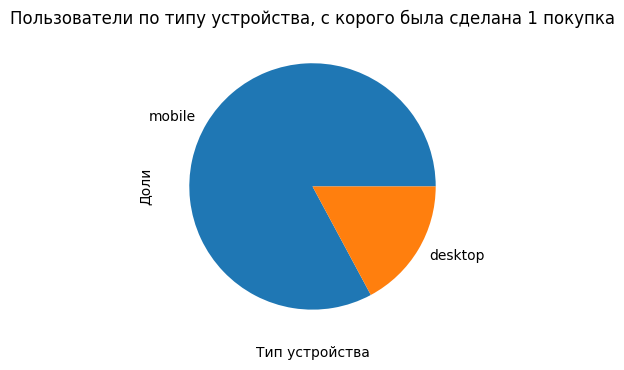

In [64]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 4))

# Строим круговую диаграмму с помощью pandas через plot(kind='pie')
uprofil_df['device_type_first'].value_counts().plot(
               kind='pie', # Тип графика — круговая диаграмма
               title=f'Пользователи по типу устройства, с корого была сделана 1 покупка'
)

# Настраиваем оформление графика
plt.xlabel('Тип устройства')
plt.ylabel('Доли')

# Выводим график
plt.show()

В подавляющем большинстве случаев первая покупка делалась пользователем с мобильного устройства.

Регионов, с территории которых была сделана первая покупка, достаточно много:

In [65]:
uprofil_df['region_name_first'].nunique()

81

Получим максимальное и минимальное значение пользователей по этому критерию:

In [66]:
print('Минимум: {}'.format(uprofil_df['region_name_first'].value_counts().min()))
print('Максимум: {}'.format(uprofil_df['region_name_first'].value_counts().max()))

Минимум: 1
Максимум: 7159


Разница между максимальным и минимальным значением пользователей очень велика, поэтому возьмем десяток регонов с максимальном значением пользователей и посмотрим тенденцию:

In [67]:
# Для параметра 'Регион'
conts_df = get_top_param('region_name_first', 'Регион')
conts_df

,Регион,Количество,Доля
0,Каменевский регион,7159,0.328199
1,Североярская область,3793,0.173887
2,Широковская область,1236,0.056663
3,Озернинский край,678,0.031082
4,Малиновоярский округ,530,0.024297
5,Шанырский регион,505,0.023151
6,Травяная область,493,0.022601
7,Светополянский округ,464,0.021272
8,Речиновская область,447,0.020492
9,Яблоневская область,417,0.019117


Столбчатую диаграмму для топ-10 посторим в нормализованном виде (в долях в данном случае):

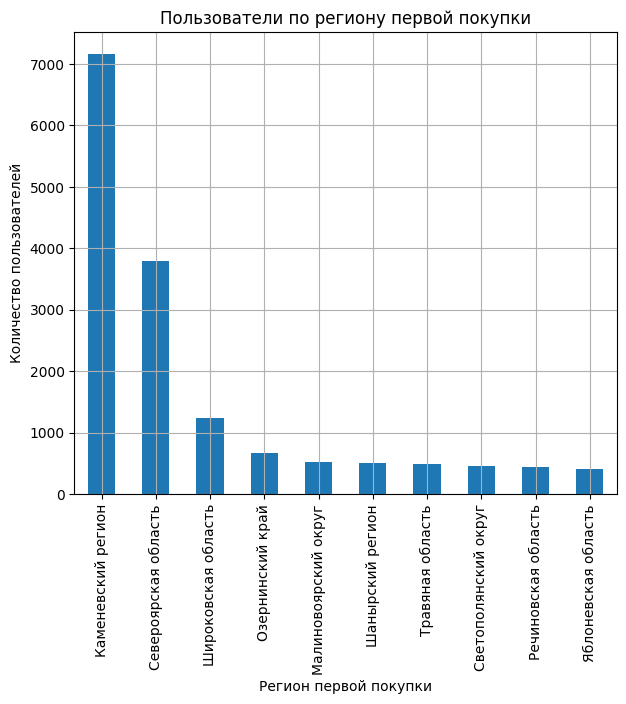

In [68]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 6))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
uprofil_df['region_name_first'].value_counts().head(10).plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=90, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Пользователи по региону первой покупки'
)

# Настраиваем оформление графика
plt.xlabel('Регион первой покупки')
plt.ylabel('Количество пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Из диаграммы видно, что неоспоримым лидером-регионом по количеству пользователей, которые сделали в нём первую покупку является Каменевский регион. Следующую строку в топе занимает Североярская область, в которой делали первую покупку почти в два раза мерньше пользователей. На слеудщем месте стоит Широковская область, в которой сделали первую покупку примерно в шесть раз мерньше пользователей, чем на территории лидера. Таким образом, количество пользователей в топе падает очень резко. Начиная с Малиновоярского округа количество пользователей держится примерно на одном низком уровне по сравнению с лидером.

В следующем признаке (колонка `service_name_first` - билетный оператор, продавший билеты на первый заказ) ситуация такая же, как для предыдущего признака. Поэтому поступим аналогично, но сделаем топ-15 для операторов с наибольшим количеством пользователей:

In [69]:
print('Билетные операторы, продавшие билеты на первый заказ:\n')
print('Всего уникальных значений: {}'.format(uprofil_df['service_name_first'].nunique()))
print('Минимум пользователей: {}'.format(uprofil_df['service_name_first'].value_counts().min()))
print('Максимум пользователей: {}'.format(uprofil_df['service_name_first'].value_counts().max()))
print('\nТоп-15 билетных операторов по количеству пользователей:\n')

conts_df = get_top_param('service_name_first', 'Билетный оператор',15)
conts_df

Билетные операторы, продавшие билеты на первый заказ:

Всего уникальных значений: 34
Минимум пользователей: 1
Максимум пользователей: 5194

Топ-15 билетных операторов по количеству пользователей:



,Билетный оператор,Количество,Доля
0,Билеты без проблем,5194,0.238115
1,Мой билет,2971,0.136203
2,Лови билет!,2853,0.130794
3,Билеты в руки,2593,0.118874
4,Облачко,2195,0.100628
5,Весь в билетах,1306,0.059873
6,Лучшие билеты,1186,0.054371
7,Прачечная,588,0.026956
8,Край билетов,459,0.021042
9,Дом культуры,356,0.016321


Столбчатая диаграмма в долях:

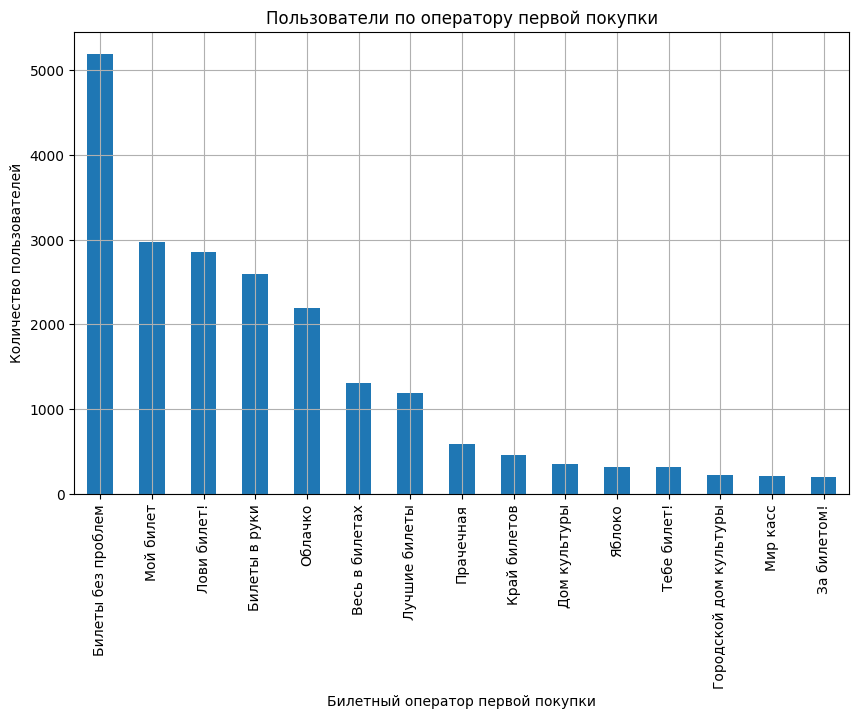

In [70]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 6))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
uprofil_df['service_name_first'].value_counts().head(15).plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=90, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Пользователи по оператору первой покупки'
)

# Настраиваем оформление графика
plt.xlabel('Билетный оператор первой покупки')
plt.ylabel('Количество пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Среди билетных операторов по количеству пользователей, сделавших через него первых заказ, есть явный лидер - `Билеты без проблем`. Далее количество пользователей от оператора к оператору падает не так резко, как в предыдущем случае. Далее операторов условно можно разделить на три группы:
- от 2000 до 3000 - операторы `Мой билет`, `Лови билет!`, `Билеты в руки`, `Облачко`;
- около 1000 - операторы `Весь в билетах`, `Лучшие билеты`;
- меньше 500 - прочие операторы.

Для кажого признака есть сегменты с наибольшим числом пользователей (или выраженные «точки входа»):
- Тип первого мероприятия - сегмент `концерты` (9629 пользователей).
- Тип устройства, с которого совершена первая покупка - сегмент `mobile` (18072 пользователей).
- Регион проведения мероприятия из первого заказа - сегмент `Каменевский регион` (7159 пользователей).
- Билетный оператор, продавший билеты на первый заказ - сегмент `Билеты без проблем` (5194 пользователей).

---
<a id='task4_1_2'></a>
**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


Доли пользователей, совершивших 2 и более покупок по типам первого мероприятия распределились следующим образом:

In [71]:
# Профили пользователей, которые сделали 2 и более заказов
up_is_two = uprofil_df[uprofil_df['is_two'] == True]

# Функция формирования датафрейма для заданного параметра
def get_top_is_two(name_col, name_param):
    # Количество пользователей, которые сделали 2 и более заказов по типу первого мероприятия
    s1 = up_is_two[name_col].value_counts().head(10)
    # Количество пользователей всего по типу певрого мероприятия
    s2 = uprofil_df[name_col].value_counts().head(10)
    # Делаем новый датафрейм с этими данными
    two_df = pd.concat([s1, s2], axis=1).reset_index()
    two_df.columns = [name_param, '2 и более покупки', 'Полное количество']
    two_df['Доля'] = two_df['2 и более покупки']/two_df['Полное количество']
    return two_df.sort_values('Доля',ascending=False)

event_two_df = get_top_is_two('event_type_first', 'Тип мероприятия')
event_two_df

,Тип мероприятия,2 и более покупки,Полное количество,Доля
5,выставки,268,416,0.644231
2,театр,2747,4299,0.638986
0,концерты,5982,9629,0.621248
3,стендап,684,1118,0.611807
1,другое,3277,5455,0.600733
4,спорт,450,801,0.561798
6,ёлки,53,95,0.557895


Для наглядности сформируем столбчатую диаграмму:

Среднее: 0.605


<Figure size 700x300 with 0 Axes>

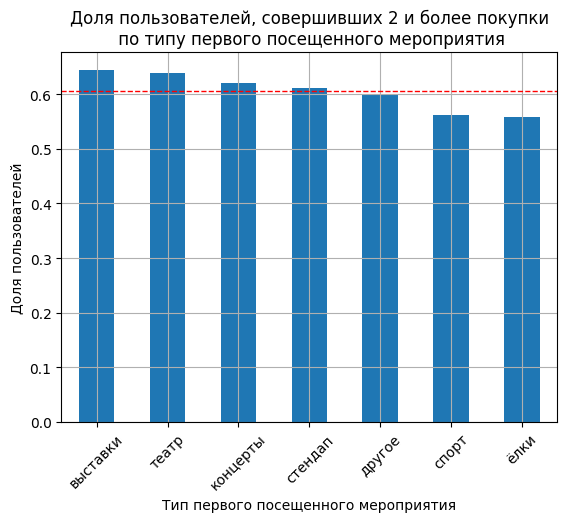

In [72]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
event_two_df.plot(
            x = 'Тип мероприятия',
            y = 'Доля',
            kind='bar', # Тип графика - столбчатая диаграмма
            rot=45, # Градус вращения подписи по оси Х
            legend=False, # Выключаем легенду
            title=f'Доля пользователей, совершивших 2 и более покупки\n по типу первого посещенного мероприятия'
)

# Рассчитываем значение среднего значения
mean_event = event_two_df['Доля'].mean()
print(f'Среднее: {mean_event:.3f}')

# Наносим на график линию со средним значением
plt.axhline(mean_event, # Данные, по которым строится линия
            color='red', # Цвет линии
            linestyle='--', # Стиль линии
            linewidth=1, # Ширина линии
            label=f'Среднее ({round(mean_event)})')

# Настраиваем оформление графика
plt.xlabel('Тип первого посещенного мероприятия')
plt.ylabel('Доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Доля повторных покупок для типа первого мероприятия пользователя изменяется незначительно (в диапазоне от 0.558 до 0.644). Получается, более половины пользователей делают повторный заказ. Среднее значениет (0.605) превышено для четырех типов мероприятия `выставки`, `театр`, `концерты` и `стендап`. На диаграмме среднее значение показано прерывистой красной линией. Следует отметить что общее количество ползователей, купивших билеты,  наибольшее для концертов, однако, для них доля повторных заказов меньше, чем для выставок, которые по количеству общему количеству пользователей идут на пятом месте. Правда, на выставки билеты покупало на порядок меньше пользователей, чем на концерты. Поэтому истинным лидером, видимо, стоит считать сегмент `театр`. На этот семент покупало билеты сравнительное количество пользователей с сегментом `концерты`.

Перейдем к доле повторных покупок по типам устройств.

In [73]:
two_df = get_top_is_two('device_type_first', 'Тип устройства')
two_df

,Тип устройства,2 и более покупки,Полное количество,Доля
1,desktop,2400,3741,0.641540
0,mobile,11061,18072,0.612052


Различие в доле повторных покупок для двух рассматриваемых типов устройств незначительно и составляет всего три сотых. Однако со стационарных устройств повторные покупки совершают чуть чаще.

Для регионов, откуда совершалась первая покупка, картина для повторных покупок следующая:

In [74]:
reg_two_df = get_top_is_two('region_name_first', 'Регион')
reg_two_df

,Регион,2 и более покупки,Полное количество,Доля
4,Шанырский регион,341,505,0.675248
5,Светополянский округ,307,464,0.661638
2,Широковская область,801,1236,0.648058
1,Североярская область,2435,3793,0.641972
8,Речиновская область,286,447,0.639821
0,Каменевский регион,4496,7159,0.628021
6,Травяная область,305,493,0.618661
9,Яблоневская область,250,417,0.599520
7,Малиновоярский округ,297,530,0.560377
3,Озернинский край,376,678,0.554572


Среднее: 0.623


<Figure size 700x300 with 0 Axes>

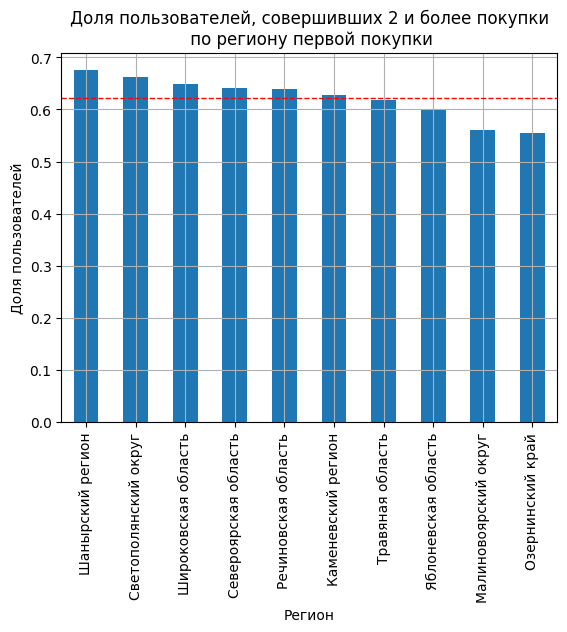

In [75]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
reg_two_df.plot(
            x = 'Регион',
            y = 'Доля',
            kind='bar', # Тип графика - столбчатая диаграмма
            rot=90, # Градус вращения подписи по оси Х
            legend=False, # Выключаем легенду
            title=f'Доля пользователей, совершивших 2 и более покупки\n по региону первой покупки'
)

# Рассчитываем значение среднего
mean_event = reg_two_df['Доля'].mean()
print(f'Среднее: {mean_event:.3f}')

# Наносим на график линию со средним значением
plt.axhline(mean_event, # Данные, по которым строится линия
            color='red', # Цвет линии
            linestyle='--', # Стиль линии
            linewidth=1, # Ширина линии
            label=f'Среднее ({round(mean_event)})')

# Настраиваем оформление графика
plt.xlabel('Регион')
plt.ylabel('Доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Доля пользователей, совершивших повторные покупки, от региона к региону изменятеся также незначительно: в пределах от 0.555 до 0.675. Но, тем не менее более половины пользователей (средняя доля 0.623) делают повторные покупки. Значения, превышающие среднее наблюдаются для шести регонов. Следует отметить, что в эти шесть регионов входят три с наибольшим количеством пользователей вообще совершивших покупки.

Доли пользователей, совершивших две и более покупок, для разных билетных операторов:

In [76]:
two_df = get_top_is_two('service_name_first', 'Билетный оператор')
two_df

,Билетный оператор,2 и более покупки,Полное количество,Доля
8,Край билетов,300,459,0.653595
9,Дом культуры,232,356,0.651685
5,Весь в билетах,828,1306,0.633997
3,Билеты в руки,1641,2593,0.632858
7,Прачечная,370,588,0.629252
4,Облачко,1351,2195,0.615490
2,Лови билет!,1755,2853,0.615142
6,Лучшие билеты,729,1186,0.614671
1,Мой билет,1813,2971,0.610232
0,Билеты без проблем,3150,5194,0.606469


Среднее: 0.626


<Figure size 700x300 with 0 Axes>

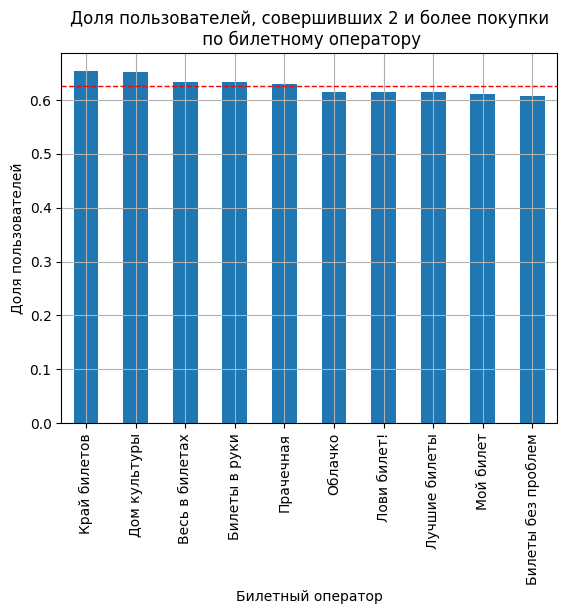

In [77]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
two_df.plot(
            x = 'Билетный оператор',
            y = 'Доля',
            kind='bar', # Тип графика - столбчатая диаграмма
            rot=90, # Градус вращения подписи по оси Х
            legend=False, # Выключаем легенду
            title=f'Доля пользователей, совершивших 2 и более покупки\n по билетному оператору'
)

# Рассчитываем значение среднего
mean_event = two_df['Доля'].mean()
print(f'Среднее: {mean_event:.3f}')

# Наносим на график линию со средним значением
plt.axhline(mean_event, # Данные, по которым строится линия
            color='red', # Цвет линии
            linestyle='--', # Стиль линии
            linewidth=1, # Ширина линии
            label=f'Среднее ({round(mean_event)})')

# Настраиваем оформление графика
plt.xlabel('Билетный оператор')
plt.ylabel('Доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Диапазон изменения доли пользователей, совершивших повторную покупку, для билетных операторов, через которых сделана первая покупка, еще более узкий, чем для других показателей: 0.606 - 0.658. Получается, что операторы работают примерно одинаково. Среднее значение доли превосходят пять билетных операторов: `Край билетов`, `Дом культуры`, `Весь в билетах`, `Билеты в руки` и `Прачечная`. Следует отметить, что оператор `Билеты без проблем` - лидер по количеству пользователей, которые покупали через него билеты, находится на последней строке топа по доле повторных покупок.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Для проверки **Гипотезы 1** возьмем две строки из датафрейма для долей пользователей, сделавших повторные покупки для типов мероприятий `концерты` и `спорт` из предыдущего пункта и сравним значения доли повторных покупок для них:

In [78]:
sport = event_two_df[event_two_df['Тип мероприятия'].isin(['спорт','концерты'])]
sport

,Тип мероприятия,2 и более покупки,Полное количество,Доля
0,концерты,5982,9629,0.621248
4,спорт,450,801,0.561798


<Figure size 500x300 with 0 Axes>

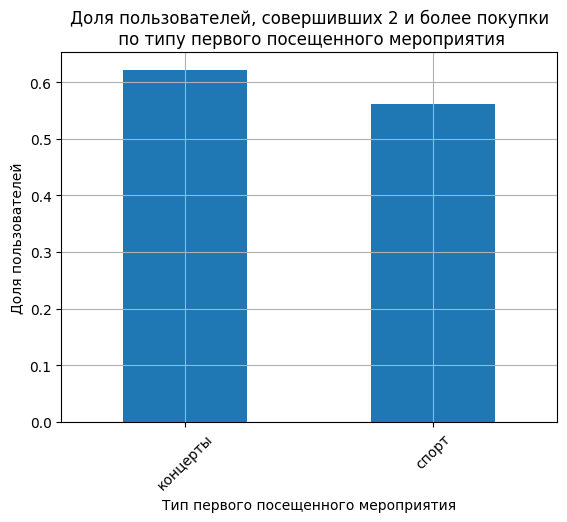

In [79]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(5, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
sport.plot(
            x = 'Тип мероприятия',
            y = 'Доля',
            kind='bar', # Тип графика - столбчатая диаграмма
            rot=45, # Градус вращения подписи по оси Х
            legend=False, # Выключаем легенду
            title=f'Доля пользователей, совершивших 2 и более покупки\n по типу первого посещенного мероприятия'
)

# Настраиваем оформление графика
plt.xlabel('Тип первого посещенного мероприятия')
plt.ylabel('Доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Сравнение показывает, что гипотеза не подтверждается: пользователи, купившие первый билет на спотивное мероприятие реже делает следующие покупки, чем любители концертов.

Теперь проверим **Гипотезу 2**. Возьмем датафрейм, в котором мы вычисляли долю пользователей, сделавших повторные покупки, в зависимости от региона первой покупки из предыдущего пункта, вычислим там долю полного количества пользователей от общего количества профилей пользователей (новая колонка `Доля по общему количеству`) и отсортируем таблицу по новой колонке:

In [80]:
reg_two_df['Доля по общему количеству'] = reg_two_df['Полное количество'] / uprofil_df.shape[0]
sort = reg_two_df.sort_values('Доля по общему количеству',ascending=False)
sort

,Регион,2 и более покупки,Полное количество,Доля,Доля по общему количеству
0,Каменевский регион,4496,7159,0.628021,0.328199
1,Североярская область,2435,3793,0.641972,0.173887
2,Широковская область,801,1236,0.648058,0.056663
3,Озернинский край,376,678,0.554572,0.031082
7,Малиновоярский округ,297,530,0.560377,0.024297
4,Шанырский регион,341,505,0.675248,0.023151
6,Травяная область,305,493,0.618661,0.022601
5,Светополянский округ,307,464,0.661638,0.021272
8,Речиновская область,286,447,0.639821,0.020492
9,Яблоневская область,250,417,0.599520,0.019117


Теперь построим столбчатую диаграмму нормализованных данных (чтобы лучше видеть тенденции) из колонок `Доля` (доля пользователей, совершающих повторные покупки по региону, от всех пользователей по региону, совершивших первую покупку) и `Доля по общему количеству` для регионов в сделанной ранее сортировке:

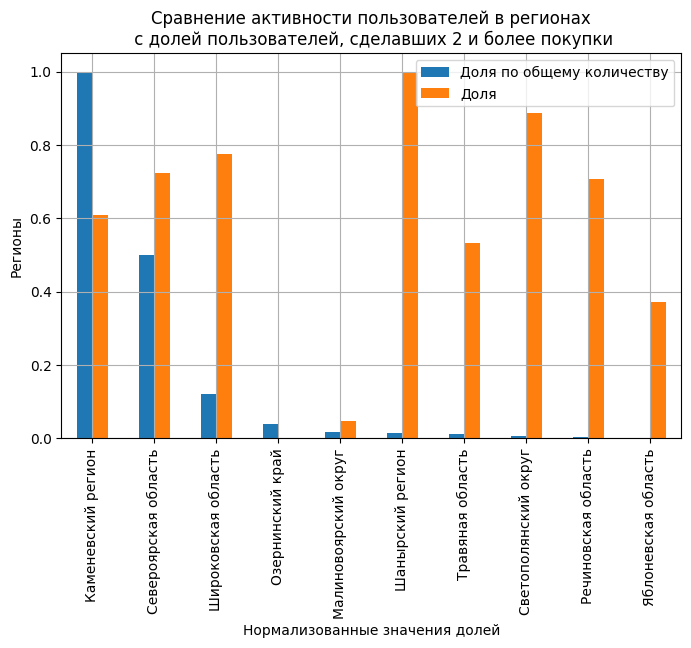

In [81]:
# Нормализация данных
sort['Доля'] = (sort['Доля'] - sort['Доля'].min())/(sort['Доля'].max() - sort['Доля'].min())
sort['Доля по общему количеству'] = (sort['Доля по общему количеству'] - sort['Доля по общему количеству'].min())/(sort['Доля по общему количеству'].max() - sort['Доля по общему количеству'].min())


# Построим график столбчатой диаграммы
sort.plot(kind='bar', x='Регион', y=['Доля по общему количеству', 'Доля'], legend=True, rot=90, figsize=(8, 5))
plt.grid()

# Добавляем подписи к осям и заголовок
plt.ylabel('Регионы')
plt.xlabel('Нормализованные значения долей')
plt.title('Сравнение активности пользователей в регионах\n с долей пользователей, сделавших 2 и более покупки')

# Выводим график
plt.show()

Как показывает диаграмма, вторая гипотеза тоже не оправдывается. И если большие значения для последних пяти регионов можно списать на нестабильность расчета доли из-за малого числа пользователей, то первые три региона противоречат гипотезе: активность пользователй вовсе не означает автоматического роста повторных покупок. В `Широковской области`, находящейся в топе всего на третьем месте самое большее значение возвратившихся пользователей.

---
<a id='analiz2'></a>
#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---
<a id='task4_2_1'></a>
**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


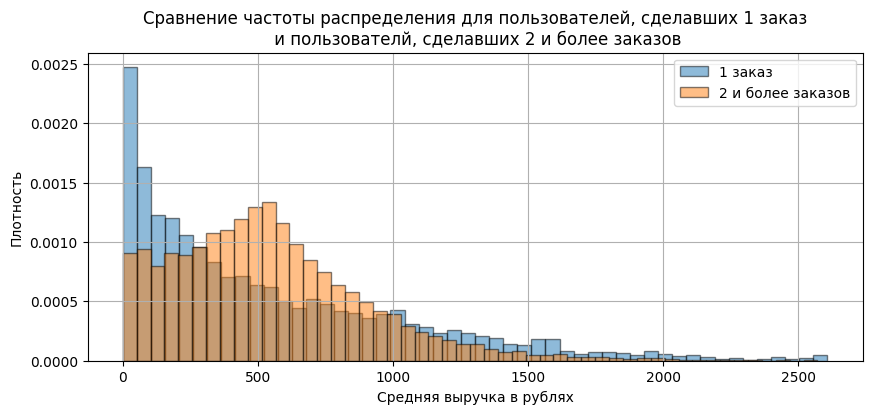

In [82]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 4))

# Гистограма для пользователей, совершивших всего 1 заказ
uprofil_df.loc[(uprofil_df['is_two'] == False) & (uprofil_df['is_five'] == False), 'revenue_rub_mean'].plot(
    kind='hist',
    label='1 заказ',
    bins=50, 
    alpha=0.5,
    edgecolor='black',
    density=True,
    legend=True
)

# Гистограмма для пользователей, совершивших 2 и более заказов
uprofil_df.loc[uprofil_df['is_two'] == True, 'revenue_rub_mean'].plot(
    kind='hist',
    label='2 и более заказов',
    bins=50, 
    alpha=0.5,
    edgecolor='black',
    density=True,
    legend=True
)

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение частоты распределения для пользователей, сделавших 1 заказ\n и пользователй, сделавших 2 и более заказов')
plt.xlabel('Средняя выручка в рублях')
plt.ylabel('Плотность')
plt.grid()
#plt.legend(title='Категория')
plt.show()    

Сравнительная гистограмма средней выручки для пользователей, сделавших 1 заказ и средней выручки для пользователей, сделавших 2 и более заказов имеют разный характер. Гистограмма для одного заказа имеет максимум пользователей для околонулевых значений выручки. Это означает что делается немало усилий, чтобы привлечь пользователей в Яндекс Афишу. Например, при продаже различных товаров в других сегментах предлагаются подарки или скидки на первый заказ в системе Яндекс Афиша. Далее интерес пользователей уменьшается, уменьшается и выручка. Для второй гистограммы характерно другое поведение. Количество пользователей растет по мере роста выручки за заказ примерно до 500 рублей. Это соответвует полученному ранее среднему значению выручки по всем профилям пользователей (545 рублей). Далее по мере роста значения средней величины выручки, количество пользователей постепенно уменьшается. Со значения около 1000 рублей, гистограммы показывают примерно одинаковое поведение.  

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


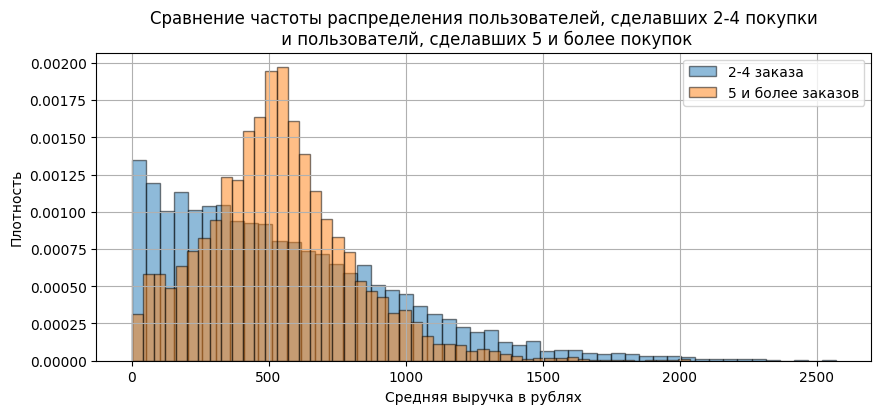

In [83]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 4))

# Гистограмма для пользователей, совершивших 2-4 заказа
uprofil_df.loc[(uprofil_df['is_two'] == True) & (uprofil_df['is_five'] == False), 'revenue_rub_mean'].plot(
    kind='hist',
    label='2-4 заказа',
    bins=50, 
    alpha=0.5,
    edgecolor='black',
    density=True,
    legend=True
)

# Гистограмма для пользователей, совершивших 5 и более заказов
uprofil_df.loc[uprofil_df['is_five'] == True, 'revenue_rub_mean'].plot(
    kind='hist',
    label='5 и более заказов',
    bins=50, 
    alpha=0.5,
    edgecolor='black',
    density=True,
    legend=True
)

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение частоты распределения пользователей, сделавших 2-4 покупки\n и пользователй, сделавших 5 и более покупок')
plt.xlabel('Средняя выручка в рублях')
plt.ylabel('Плотность')
plt.grid()
#plt.legend(title='Категория')
plt.show()    

При рассмотрении сравнительной гистограммы средней выручки для пользователей, совершивших 2-4 заказа, и для пользователей, сделавших 5 и более заказов можно сказать, что их поведение похоже на то, что мы видели для предыдущей диаграммы. Только максимум количества пользователей с минимальной выручкой в случае 2-4 заказов значительно меньше, чем в случае с пользователями, которые сделали 1 заказ и не вернулись. Далее гистограмма ведет себя почти линейно, показывая постепенное уменьшение количества пользователей. Видимо, и тут предпринимаются усилия для повторного привлечеия пользователя различными акциями, поэтому максимум пользователей приходится на околонулевую выручку. В случае с пользователями, сделавшими 5 и более заказов мы видим более резкий подъем количества пользователей при росте средней выручки примерно до 500 рублей, затем более резкое уменьшение. 

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

Разделим данные из профилей пользователелей на сегменты по количествам билетов в заказах. Посчитаем, сколько пользователей делали заказов по каждому билетному сегменту. Посчитаем долю пользователей по каждому сегменту, которые сделали 2 заказа и больше (т.е по пользователям которые вернулись на сервис).

In [84]:
tickets_df = uprofil_df.copy()

# Функция заполнения сегментов по количеству билетов
def get_ticket_seg(row):
    if row['tickets_mean'] <= 2:
        return 'от 1 до 2 билетов'
    elif row['tickets_mean'] <= 3:
        return 'от 2 до 3 билетов'
    elif row['tickets_mean'] <= 5:
        return 'от 3 до 5 билетов'
    
    return 'от 5 и более'

tickets_df['ticket_seg'] = tickets_df.apply(get_ticket_seg, axis=1)

# Количество пользователей, которые сделали 2 и более заказов по билетному сегменту
s1 = tickets_df[tickets_df['is_two'] == True]['ticket_seg'].value_counts()
# Количество пользователей всего по билетному сегменту
s2 = tickets_df['ticket_seg'].value_counts()
# Делаем новый датафрейм с этими данными
two_df = pd.concat([s1, s2], axis=1).reset_index()
two_df.columns = ['Билетный сегмент', '2 и более покупки', 'Полное количество']
two_df['Доля'] = two_df['2 и более покупки']/two_df['Полное количество']
two_df

,Билетный сегмент,2 и более покупки,Полное количество,Доля
0,от 2 до 3 билетов,7600,10147,0.748990
1,от 3 до 5 билетов,3302,5298,0.623254
2,от 1 до 2 билетов,2512,6199,0.405227
3,от 5 и более,47,169,0.278107


Построим столбчатую диаграмму распределения пользователей по билетным сегментам:

<Figure size 500x300 with 0 Axes>

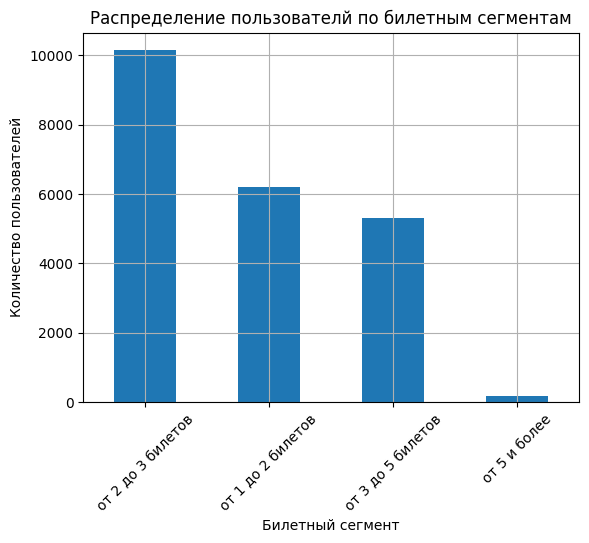

In [85]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(5, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
two_df.sort_values('Полное количество',ascending=False).plot(
            x = 'Билетный сегмент',
            y = 'Полное количество',
            kind='bar', # Тип графика - столбчатая диаграмма
            rot=45, # Градус вращения подписи по оси Х
            legend=False, # Выключаем легенду
            title=f'Распределение пользователй по билетным сегментам'
)

# Настраиваем оформление графика
plt.xlabel('Билетный сегмент')
plt.ylabel('Количество пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Пользователи по билетным сегментам распределены сконцентрированно. Максимальное количество пользователей покупают от 2 до 3 билетов. В сегментах `от 1 до 2 билетов` и `от 3 до 5 билетов` находится примерно одинаковое количество пользователей. От 5 билетов и более покупают незначительное количество пользователей.

Теперь посмотрим диаграмму доли повторных заказов по билетным сегментам:

<Figure size 500x300 with 0 Axes>

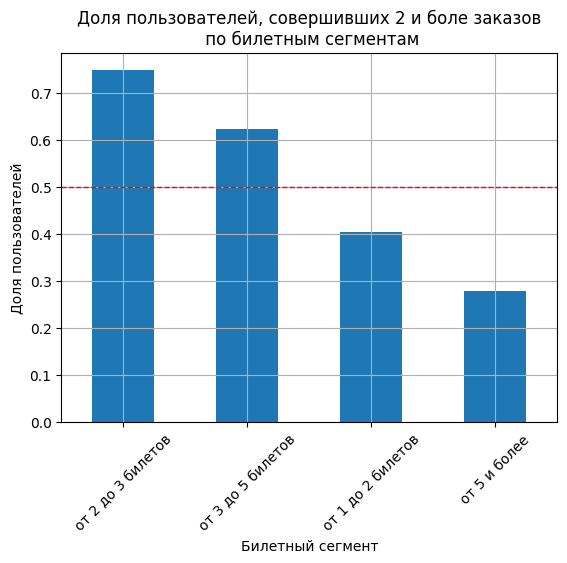

In [86]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(5, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
two_df.sort_values('Доля',ascending=False).plot(
            x = 'Билетный сегмент',
            y = 'Доля',
            kind='bar', # Тип графика - столбчатая диаграмма
            rot=45, # Градус вращения подписи по оси Х
            legend=False, # Выключаем легенду
            title=f'Доля пользователей, совершивших 2 и боле заказов\n по билетным сегментам'
)

# Наносим на график линию со половиной пользователей )))
plt.axhline(0.5, # Данные, по которым строится линия
            color='red', # Цвет линии
            linestyle='--', # Стиль линии
            linewidth=1, # Ширина линии
            label=f'Среднее ({round(mean_event)})')

# Настраиваем оформление графика
plt.xlabel('Билетный сегмент')
plt.ylabel('Доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

В топе долей повторного заказа аномально высоких или низких значений нет. Однако, следует отметить, что если для лидирующих сегментов `от 2 до 3 билетов` и `от 3 до 5 билетов` повторные заказы совершают более половины пользователей, то для двух последних сегментов `от 1 до 2 билетов` и `от 5 билетов и более` возвращаются за новым заказом менее половины пользователей. 

---
<a id='analiz3'></a>
#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


Из даты первого заказа выделим день недели. Затем для каждого дня недели выделим пользователй, которые делали в этот день первый заказ. Затем, распределим по дням недели пользователей, которые делали 2 и более закзаов и посчитаем их долю по полному количеству пользователей, которые делали первый заказ в этот день:

In [87]:
weekday_df = uprofil_df.copy()

# Функция заполнения сегментов по количеству билетов
def get_weekday(row):
    weekdays = ['пн','вт','ср','чт','пт','сб','вс']
    return weekdays[int(row['Номер дня недели'])]

#weekday_df['weekday'] = weekday_df.apply(get_weekday, axis=1)
weekday_df['nweekday'] = weekday_df['order_ts_first'].dt.weekday

# Количество пользователей, которые сделали 2 и более заказов по билетному сегменту
s1 = weekday_df[tickets_df['is_two'] == True]['nweekday'].value_counts()
# Количество пользователей всего по билетному сегменту
s2 = weekday_df['nweekday'].value_counts()
# Делаем новый датафрейм с этими данными
two_df = pd.concat([s1, s2], axis=1).reset_index()
two_df.columns = ['Номер дня недели', '2 и более покупки', 'Полное количество']
two_df['Доля'] = two_df['2 и более покупки']/two_df['Полное количество']
#two_df.dtypes
two_df['День недели'] = two_df.apply(get_weekday, axis=1)
two_df = two_df.sort_values('Номер дня недели')
two_df[['День недели','2 и более покупки', 'Полное количество','Доля']]

,День недели,2 и более покупки,Полное количество,Доля
5,пн,1853,2933,0.631776
1,вт,1969,3177,0.619767
3,ср,1915,3068,0.624185
4,чт,1856,3115,0.595827
2,пт,1946,3257,0.597482
0,сб,2221,3456,0.642650
6,вс,1701,2807,0.605985


Количества пользователей, которые сделали 2 и более закзаов, по дням недели представим в виде столбчатой диаграммы по дням недели:

<Figure size 500x300 with 0 Axes>

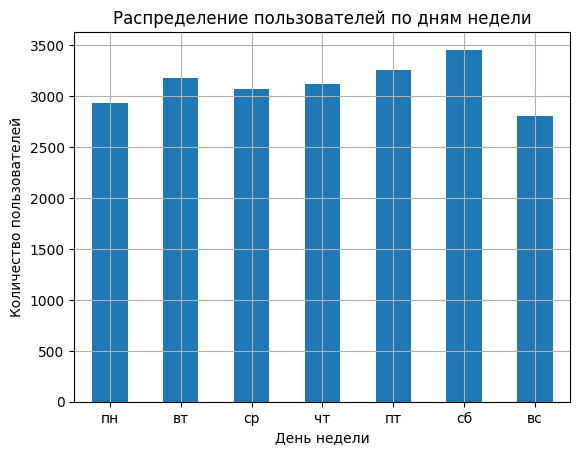

In [88]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(5, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
two_df.plot(
            x = 'День недели',
            y = 'Полное количество',
            kind='bar', # Тип графика - столбчатая диаграмма
            rot=0, # Градус вращения подписи по оси Х
            legend=False, # Выключаем легенду
            title=f'Распределение пользователей по дням недели'
)

# Настраиваем оформление графика
plt.xlabel('День недели')
plt.ylabel('Количество пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Пользователи по дням недели покупок распределены практически равномерно. Однако, от понедельника к субботе количество пользователей, делающих заказы возрастает, а в воскресенье резко падает. Разброс между максимальным и минимальным значением небольшой:

In [89]:
print('Разброс: {}'.format(two_df['Полное количество'].max()-two_df['Полное количество'].min()))

Разброс: 649


Распределение долей пользователей, повторно сделавших заказ, показано ниже по дням недели:

Среднее: 0.626


<Figure size 500x300 with 0 Axes>

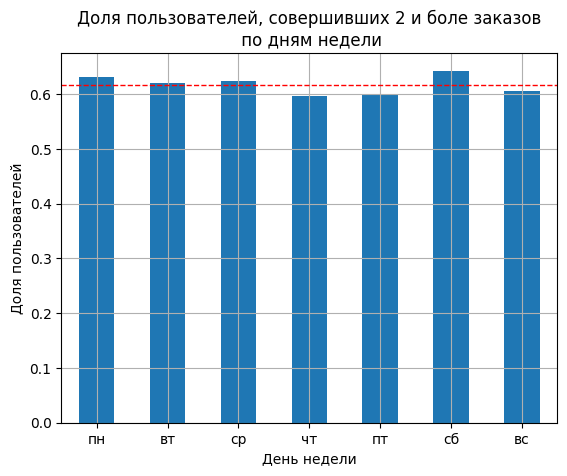

In [90]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(5, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
two_df.plot(
            x = 'День недели',
            y = 'Доля',
            kind='bar', # Тип графика - столбчатая диаграмма
            rot=0, # Градус вращения подписи по оси Х
            legend=False, # Выключаем легенду
            title=f'Доля пользователей, совершивших 2 и боле заказов\n по дням недели'
)

# Рассчитываем значение среднего
mean_zn = two_df['Доля'].mean()
print(f'Среднее: {mean_event:.3f}')

# Наносим на график линию со средним значением
plt.axhline(mean_zn, # Данные, по которым строится линия
            color='red', # Цвет линии
            linestyle='--', # Стиль линии
            linewidth=1, # Ширина линии
            label=f'Среднее ({round(mean_event)})')

# Настраиваем оформление графика
plt.xlabel('День недели')
plt.ylabel('Доля пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Для облегчения сравнения на диаграмме показано среднее значение доли. Тут диапазон изменения тоже небольшой: 0.596 - 0.642. Однако, следует отметить, что для субботы полное количество, сделавших заказы пользователей и доля из них, совершивших повторную покупку максимальны как первом, так и во втором топе. Значит, суббота в каком-то роде является оптимальным днем. 

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


 Среднее время между заказами для пользователей, сделавших 2-4 заказа:

In [91]:
df_2_4 = uprofil_df[(uprofil_df['is_two']==True) & (uprofil_df['is_five']==False)]
print('{:.3f}'.format(df_2_4['days_since_prev_mean'].mean()))

20.774


В то же время среднее время между заказами для пользователей, сделавших 5 и более заказов:

In [92]:
df_5 = uprofil_df[uprofil_df['is_five']==True]
print('{:.3f}'.format(df_5['days_since_prev_mean'].mean()))

10.715


Сравнительная гистрограмма среднего времени между заказами для этих двух групп пользователей:

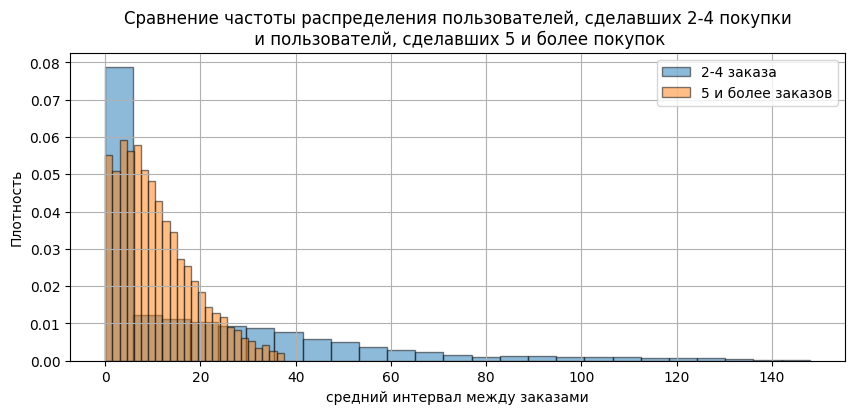

In [93]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 4))

# Гистограмма для пользователей, совершивших 2-4 заказа
df_2_4['days_since_prev_mean'].plot(
    kind='hist',
    label='2-4 заказа',
    bins=25, 
    alpha=0.5,
    edgecolor='black',
    density=True,
    legend=True
)

# Гистограмма для пользователей, совершивших 5 и более заказов
df_5['days_since_prev_mean'].plot(
    kind='hist',
    label='5 и более заказов',
    bins=25, 
    alpha=0.5,
    edgecolor='black',
    density=True,
    legend=True
)

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение частоты распределения пользователей, сделавших 2-4 покупки\n и пользователй, сделавших 5 и более покупок')
plt.xlabel('средний интервал между заказами')
plt.ylabel('Плотность')
plt.grid()
#plt.legend(title='Категория')
plt.show()    

Из гистограммы следует для сегмента 2-4 заказов наблюдается пик количества пользователей для околонулевых значений среднего времени между заказами. Затем гистограмма плавно снижается. Попробуем разобраться с причиной возникновения пика. Посмотрим, каким именно значениям времени между заказами соответствует пик:

In [94]:
df_2_4['days_since_prev_mean'].value_counts().head()

days_since_prev_mean
0.0    2656
1.0     163
2.0     104
3.0      83
8.0      77
Name: count, dtype: int64

Получается, что пик соответствует нулевым значениям времени между заказами. Такие значения возможны лишь в том случае, когда все заказы делаются в один день. Посмотрим несколько профилей пользователей с нулевым значением времени между заказами:

In [95]:
df_2_4[df_2_4['days_since_prev_mean']==0].head()

,user_id,order_ts_first,order_ts_last,orders_count,revenue_rub_mean,tickets_mean,days_since_prev_mean,device_type_first,region_name_first,service_name_first,event_type_first,is_two,is_five
6,00147c9209d45d3,2024-06-25 23:26:58,2024-06-25 23:28:52,2,352.945000,1.500000,0.0,mobile,Каменевский регион,Облачко,концерты,True,False
10,0020c5654c92ec1,2024-07-02 22:57:17,2024-07-02 22:58:04,2,193.420000,2.000000,0.0,mobile,Каменевский регион,Билеты без проблем,концерты,True,False
38,0071edbfd17f23f,2024-10-25 19:35:27,2024-10-25 20:24:17,3,1150.906667,2.666667,0.0,mobile,Каменевский регион,Мой билет,концерты,True,False
57,00b5d21f6ef3dee,2024-08-28 13:22:21,2024-08-28 13:31:16,3,860.116667,2.666667,0.0,mobile,Каменевский регион,Весь в билетах,другое,True,False
66,00d6b4664563530,2024-08-02 10:33:37,2024-08-02 10:34:26,2,273.600000,3.500000,0.0,desktop,Травяная область,Лови билет!,концерты,True,False


Действительно, первый и последний заказ делались в один день с разницей даже в несколько минут. Видимо, пользователь докупал билеты на одно и то же мероприятие. Эти ситуации не очень соотносятся с задачей повторного привлчения пользователей к покупке билетов на другие мероприятия в другие дни. Поэтому профили с нулевым временем межу заказами из анализа лучше исключить.

Посмотрим сравнительную гистограмму без нулевого времени между заказами:

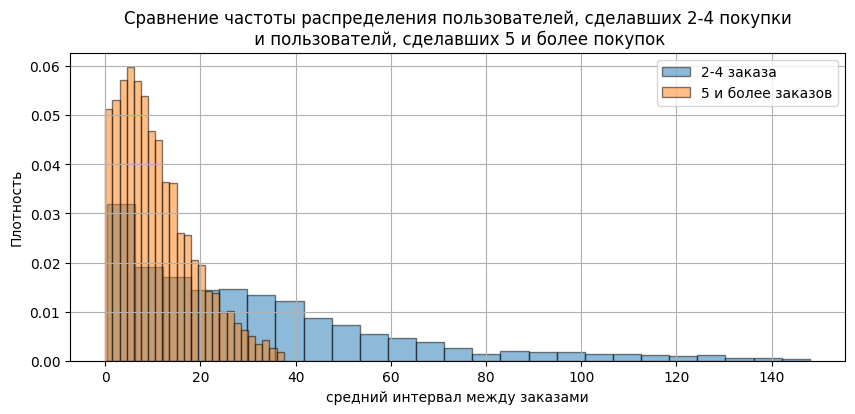

In [96]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 4))

# Гистограмма для пользователей, совершивших 2-4 заказа
df_2_4.loc[df_2_4['days_since_prev_mean'] > 0,'days_since_prev_mean'].plot(
    kind='hist',
    label='2-4 заказа',
    bins=25, 
    alpha=0.5,
    edgecolor='black',
    density=True,
    legend=True
)

# Гистограмма для пользователей, совершивших 5 и более заказов
df_5.loc[df_5['days_since_prev_mean'] > 0,'days_since_prev_mean'].plot(
    kind='hist',
    label='5 и более заказов',
    bins=25, 
    alpha=0.5,
    edgecolor='black',
    density=True,
    legend=True
)

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение частоты распределения пользователей, сделавших 2-4 покупки\n и пользователй, сделавших 5 и более покупок')
plt.xlabel('средний интервал между заказами')
plt.ylabel('Плотность')
plt.grid()
#plt.legend(title='Категория')
plt.show()    

Теперь пик в обеих группах пользователй пропал и можно более спокойно оценить их поведение. Если для первой группы пользователей (2-4 заказа) имеется небольшой пик количества пользователей для одного дня между заказами и затем линия гистограммы постепенно снижается чуть ли не 120 дней между заказами, то для второй группы (3 заказов и более) мы имеем выраженный пик для малого количества дней и затем довольно быстрое падение количества пользователей к 40 дням. Такое поведение кажется более логичным, постоянный активный покупатель не будет делать большие временные интервалы между заказами. Максимальная оценка в 40 дней вполне адекватна.

---
<a id='analiz4'></a>
#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

Рассчитаем коэффициенты корреляции `phi_k` между числом заказов пользователей `orders_count` и рассмотренными ранее признаками профиля пользователя, связанными с первым заказом пользователя:
- `region_name_first` - регион, в котором пользователь сделал первый заказ;
- `service_name_first` - билетный оператор, которым пользователй воспользовался при первом заказе;
- `device_type_first` - тип устройства, с которого сделан первый заказ;
- `event_type_first` - тип первого посещенного мероприятия.

In [97]:
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix = uprofil_df[['device_type_first', 'region_name_first', 'service_name_first', 'event_type_first',
                         'orders_count']].phik_matrix()

# Выводим результат
print('Корреляционная матрица с коэффициентом phi_k для переменной orders_count')
correlation_matrix.loc[correlation_matrix.index != 'orders_count'][['orders_count']].sort_values(by='orders_count', ascending=False)

interval columns not set, guessing: ['orders_count']
Корреляционная матрица с коэффициентом phi_k для переменной orders_count


,orders_count
region_name_first,0.128309
service_name_first,0.101755
device_type_first,0.000000
event_type_first,0.000000


Коэффициеты phi_k для двух первых признаков очень малы, а для двух последних вообще равны нулю. Попробуем добавить признак, связанный с количеством заказов, сделанных пользователем. Назовем его `count_seg` и выделим в нем следующие сегменты:
- 1 заказ
- от 2 до 4 заказов;
- от 5 и выше.

Кроме того, добавим числовые колонки `revenue_rub_mean` (средняя выручка по пользователю) и `days_since_prev_mean` (среднее время между заказами). Явно укажем, что они числовые:

In [98]:
# Функция заполнения сегментов по количеству билетов
def get_ord_count_seg(row):
#df_2_4 = uprofil_df[(uprofil_df['is_two']==True) & (uprofil_df['is_five']==False)]
    if row['is_two']==False and row['is_five']==False:
        return '1 заказ'
    elif row['is_two']==True and row['is_five']==False:
        return 'от 2 до 4 заказов'
    elif row['is_five']==True:
        return 'от 5 и выше'

uprofil_df['count_seg'] = uprofil_df.apply(get_ord_count_seg, axis=1)
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix = uprofil_df[['device_type_first', 'region_name_first', 'service_name_first', 'event_type_first',
        'count_seg', 'revenue_rub_mean', 'days_since_prev_mean', 'orders_count']].phik_matrix(interval_cols=['revenue_rub_mean', 'days_since_prev_mean'])

# Выводим результат
print('Корреляционная матрица с коэффициентом phi_k для переменной orders_count')
correlation_matrix.loc[correlation_matrix.index != 'orders_count'][['orders_count']].sort_values(by='orders_count', ascending=False)

Корреляционная матрица с коэффициентом phi_k для переменной orders_count


,orders_count
count_seg,1.000000
days_since_prev_mean,0.573368
service_name_first,0.297509
region_name_first,0.216088
revenue_rub_mean,0.215337
device_type_first,0.027075
event_type_first,0.000000


Катрина резко поменялась. Коэффициент `phi_k` для введенного нами нового признака равен 1. Связь очень сильная. Менее сильная связь между средним временем между заказами и числом заказов пользователей (0.573). Наглядно представить значения коэффициента корреляции `phi_k` для рассматриваемых признаков можно при помощи тепловой карты:

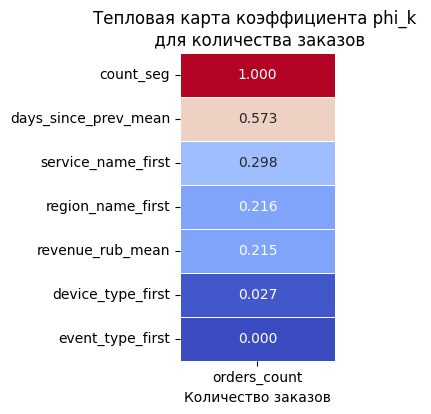

In [99]:
# Строим тепловую карту
plt.figure(figsize=(2, 4))

# Сохраняем матрицу корреляции признака рейтинга с другими параметрами
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'orders_count'][['orders_count']].sort_values(by='orders_count', ascending=False)
sns.heatmap(data_heatmap,
            annot=True, # Отображаем численные значения в ячейках карты
            fmt='.3f', # Форматируем значения корреляции: три знака после точки
            cmap='coolwarm', # Устанавливаем цветовую гамму от красного (макс. значение) к синему
            linewidths=0.5, # Форматируем линию между ячейками карты
            cbar=False # Отключаем цветовую шкалу
            #rot=0
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \n для количества заказов')
plt.xlabel('Количество заказов')

# Выводим график
plt.show()

Коэффициент phi_k показывает силу связи, но не дает представление о ее направлении. Для двух параметров с наиболее сильной связью посмотрим направление связи.

Сгруппируем пользователей по сегментам с количеством заказов `count_seg` и посмотрим общее количество заказов, которые сделали пользователи по сегментам: 

In [100]:
uprofil_df.groupby('count_seg')['orders_count'].sum()

count_seg
1 заказ                8352
от 2 до 4 заказов     20398
от 5 и выше          219745
Name: orders_count, dtype: int64

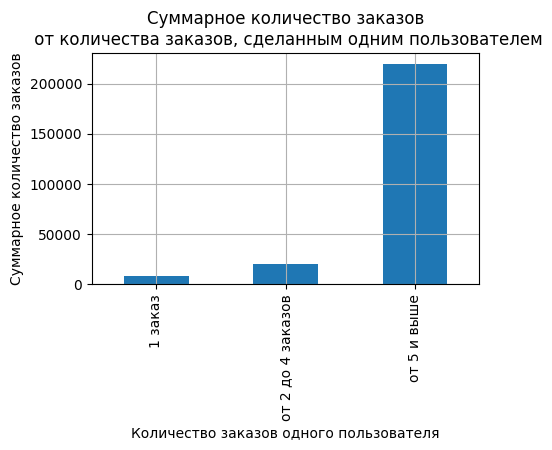

In [101]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(5, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
uprofil_df.groupby('count_seg')['orders_count'].sum().plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=90, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Суммарное количество заказов\n от количества заказов, сделанным одним пользователем'
)

# Настраиваем оформление графика
plt.xlabel('Количество заказов одного пользователя')
plt.ylabel('Суммарное количество заказов')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Из столбчатой диаграммы видно, что связь положительная: чем больше сделал пользователь заказов, тем больше заказов сделали все пользователи сегмента.

То же самое посмотрим для среднего времени между заказами. Только сначала округлим значения параметра до целого, чтобы уменьшить количество элементов в выборке.

In [102]:
uprofil_df['days_since_prev_mean'] = uprofil_df['days_since_prev_mean'].round()

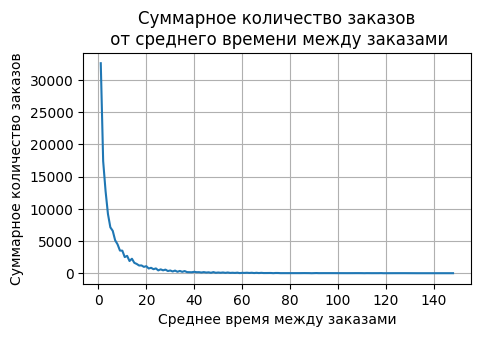

In [103]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(5, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
uprofil_df[uprofil_df['days_since_prev_mean']>0].groupby('days_since_prev_mean')['orders_count'].sum().plot(
               kind='line', # Тип графика - линия
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Суммарное количество заказов\n от среднего времени между заказами'
)

# Настраиваем оформление графика
plt.xlabel('Среднее время между заказами')
plt.ylabel('Суммарное количество заказов')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

<a id='conclusion'></a>
### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

#### 5.1 Информация о данных

При проведении данной работы были использованы данные о заказах пользователей Яндекс Афиши. Данные были загружены из удаленного PostgeSQL сервера при помощи SQL запроса и помещены в датафрейм `df`. Датафрейм содержал 14 столбцов и 290611 строк с информацией о покупках пользователями билетов на разные мероприятия у различных билетных операторов по разным городам и регионам ([см.ссылку](#zagr)).

Была проведена предобработка данных в процессе которой было выяснено, что данные о выручке были в двух валютах, поэтому к датафрейму была добавлена дополнительная колонка для валюты в рублях. Эта колонка была заполнена рублевыми значениями выручки, а для другой валюты путем пересчета при помощи предварительно загруженного датафрейма с курсом валюты. Пропуски были замечены только в одной числовой колонке и заполнены значениями `-1`. Были выявлены неявные дубликаты, когда все значения в ячейках строк совпадали, кроме номера заказа и его времени. Эти дубли были призаны ошибочными и удалены. Были обнаружены отрицательные значения выручки. Строк с такими значениями было немного, поэтому они были удалены из датафрейма. Были проверены распределения количественных данных. При статистическом анализе колонки `revenue_rub` было выявлено, что максимальное значение выручки на несколько порядков превосходит как медианное, так и среднее значение. Выручка, соответствующая 99 перценталю также оказалась примерно в 40 раз меньше максимального значения. Поэтому было решено удалить из датафрейма строки с выручкой, превышающей её значение для 99 перценталя. Всего с учетом удаления дублей записей с одинаковыми значениями во всех колонках, кроме номера заказа и времени, а также отрицательных значений выручки было удалено 42095 строк, что составило 14.48% от общего количества строк Более подробные данные о предобработке данных: [см.ссылку](#predv).

Для дальнейшего анализа был создан отдельный датафрейм с профилями пользователей, куда вошли колонки, относящиеся к параметрам первого заказа, количество заказов, другие количественные характеристики, необходимые для анализа, а также были добавлены два бинарных столбца, выделяющие профили пользователей, которые совершили 2 и более покупок, а таже пользователей, которые сделали 5 и более покупок ([см.ссылку](#uprofil)).

#### 5.2 Основные результаты анализа

В датафрейме с профилями пользователей 21825 строк. Из них:
- 2 и более заказов сделали 13467 (доля от общего количества: 61.70%)
- 5 и более заказов: 5894, доля от общего количества: 27.01%

Распределение пользователей по числу заказов ассметричное. Наибольшее число пользователей делают мало заказов. Однако стандартное отклонение в распределении небольшое всего 121 один заказ. Много выбросов. Максимальное значение заказов на одного пользователя 10168. Также были рассмотрены статистические параметры по общему числу заказов, по среднему числу билетов в заказе и по среднему количеству дней между покупками ([см.ссылку](#task3_2)).

Было проведено исследование о том, влияют ли на возврат покупателя следующие признаки:
- тип их первого мероприятия;
- тип устройства, с которого совершена первая покупка;
- регион проведения мероприятия из первого заказа;
- билетномый оператор, продавший билеты на первый заказ.

Были получены следующие результаты ([см.ссылку](#task4_1_2)):

Доля повторных покупок для типа первого мероприятия пользователя изменяется незначительно (в диапазоне от 0.558 до 0.644). Получается, более половины пользователей делают повторный заказ. Среднее значениет (0.605) превышено для четырех типов мероприятия выставки, театр, концерты и стендап. На диаграмме среднее значение показано прерывистой красной линией. Следует отметить что общее количество ползователей, купивших билеты, наибольшее для концертов, однако, для них доля повторных заказов меньше, чем для выставок, которые по количеству общему количеству пользователей идут на пятом месте. Правда, на выставки билеты покупало на порядок меньше пользователей, чем на концерты. Поэтому истинным лидером, видимо, стоит считать сегмент театр. На этот семент покупало билеты сравнительное количество пользователей с сегментом концерты.

Различие в доле повторных покупок для двух рассматриваемых типов устройств незначительно и составляет всего три сотых. Однако со стационарных устройств повторные покупки совершают чуть чаще.

Доля пользователей, совершивших повторные покупки, от региона к региону изменятеся также незначительно: в пределах от 0.555 до 0.675. Но, тем не менее более половины пользователей (средняя доля 0.623) делают повторные покупки. Значения, превышающие среднее наблюдаются для шести регонов. Следует отметить, что в эти шесть регионов входят три с наибольшим количеством пользователей вообще совершивших покупки.

Диапазон изменения доли пользователей, совершивших повторную покупку, для билетных операторов, через которых сделана первая покупка, еще более узкий, чем для других показателей: 0.606 - 0.658. Получается, что операторы работают примерно одинаково. Среднее значение доли превосходят пять билетных операторов: `Край билетов`, `Дом культуры`, `Весь в билетах`, `Билеты в руки` и `Прачечная`. Следует отметить, что оператор `Билеты без проблем` - лидер по количеству пользователей, которые покупали через него билеты, находится на последней строке топа по доле повторных покупок.

При анализе того, как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок были получены следующие результаты ([см.ссылку](#task4_2_1)):

Сравнительная гистограмма средней выручки для пользователей, сделавших 1 заказ и средней выручки для пользователей, сделавших 2 и более заказов имеют разный характер. Гистограмма для одного заказа имеет максимум пользователей для околонулевых значений выручки. Это означает что делается немало усилий, чтобы привлечь пользователей в Яндекс Афишу. Например, при продаже различных товаров в других сегментах предлагаются подарки или скидки на первый заказ в системе Яндекс Афиша. Далее интерес пользователей уменьшается, уменьшается и выручка. Для второй гистограммы характерно другое поведение. Количество пользователей растет по мере роста выручки за заказ примерно до 500 рублей. Это соответвует полученному ранее среднему значению выручки по всем профилям пользователей (545 рублей). Далее по мере роста значения средней величины выручки, количество пользователей постепенно уменьшается. Со значения около 1000 рублей, гистограммы показывают примерно одинаковое поведение.

При рассмотрении сравнительной гистограммы средней выручки для пользователей, совершивших 2-4 заказа, и для пользователей, сделавших 5 и более заказов можно сказать, что их поведение похоже на то, что мы видели для предыдущей диаграммы. Только максимум количества пользователей с минимальной выручкой в случае 2-4 заказов значительно меньше, чем в случае с пользователями, которые сделали 1 заказ и не вернулись. Далее гистограмма ведет себя почти линейно, показывая постепенное уменьшение количества пользователей. Видимо, и тут предпринимаются усилия для повторного привлечеия пользователя различными акциями, поэтому максимум пользователей приходится на околонулевую выручку. В случае с пользователями, сделавшими 5 и более заказов мы видим более резкий подъем количества пользователей при росте средней выручки примерно до 500 рублей, затем более резкое уменьшение.

Пользователи по билетным сегментам распределены сконцентрированно. Максимальное количество пользователей покупают от 2 до 3 билетов. В сегментах `от 1 до 2 билетов` и `от 3 до 5 билетов` находится примерно одинаковое количество пользователей. От 5 билетов и более покупают незначительное количество пользователей.

В топе долей повторного заказа аномально высоких или низких значений нет. Однако, следует отметить, что если для лидирующих сегментов `от 2 до 3 билетов` и `от 3 до 5 билетов` повторные заказы совершают более половины пользователей, то для двух последних сегментов `от 1 до 2 билетов` и `от 5 билетов и более` возвращаются за новым заказом менее половины пользователей.

Кроме того, было рассмотрено, какие временные характеристики влияют на удержание (день недели, интервалы между покупками). И получены следующие результаты ([см.ссылку](#analiz3)): 

Пользователи по дням недели покупок распределены практически равномерно. Разброс между максимальным и минимальным значением небольшой (646 пользователей). Для долей пользователей, повторно сделавших заказ, диапазон изменения тоже небольшой: 0.596 - 0.642. Однако, следует отметить, что для субботы полное количество, сделавших заказы пользователей и доля из них, совершивших повторную покупку максимальны как первом, так и во втором топе. Значит, суббота в каком-то роде является оптимальным днем.

Для группы пользователей `2-4 заказа` имеется небольшой пик количества пользователей для одного дня между заказами и затем линия гистограммы постепенно снижается чуть ли не 120 дней между заказами, то для группы `5 заказов и более` мы имеем выраженный пик для малого количества дней и затем довольно быстрое падение количества пользователей к 40 дням. Такое поведение кажется более логичным, постоянный активный покупатель не будет делать большие временные интервалы между заказами. Максимальная оценка в 40 дней для этой группы вполне адекватна.

Далее был проведен корреляционный анализ количества покупок и признаков пользователя ([см.ссылку](#analiz4)).

После расчета коэффициента корреляции `phi_k` между числом заказов пользователей `orders_count` и рассмотренными ранее признаками профиля пользователя, связанными с первым заказом пользователя:
- `region_name_first` - регион, в котором пользователь сделал первый заказ;
- `service_name_first` - билетный оператор, которым пользователй воспользовался при первом заказе;
- `device_type_first` - тип устройства, с которого сделан первый заказ;
- `event_type_first` - тип первого посещенного мероприятия

стало возможным сделать вывод, что наиболее сильно число заказов пользователей зависит от региона первого заказа и билетного оператора. Однако связь с вышеуказанными параметрами оказалась близка к нулю. Поэтому был дополнительно введен признак, связанный с количеством заказов, сделанных пользователем. Кроме того были добавлены числовые параметры: средняя выручка и среднее время между заказами. После этого картина резко поменялась. Новый коэффициент показал значение коэффициента корреляции `phi_k` равный единице, что означает сильную связь. Менее сильная связь оказалась между средним временем между заказами и числом заказов пользователей (0.573). Коэффициент `phi_k` дает представление о силе связи, но не о ее направлении. Дальнейшие расчеты показали, что в первом случае связь положительная, а во втором - отрицательная. 

Следует внимательнее отнестись к повторам заказов в первый день. Они могуть быть связаны с техническими проблемами или ошибками пользователя, а не с желанием повторно воспользоваться сервисом.

<a id='final'></a>
### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**
https://github.com/vict0r8632/analysis_affiche